## FITclass &mdash; Classifying Fitness Time Series Data

In this notebook, we will explore a dataset with over **160000 tracked fitness workouts** and will try to use them to perform a **multiclass classification into sports types**. The main features will be time series logs of heart rate and speed (calculated e.g. via GPS logs). The notebook consists of all crucial parts for the project steps (dataset exploration/analysis, classification training and evaluation).

Adiitionally, some functionalities are provided in a separate `utils.ipynb` notebook, which contains a DataExplorer for time series visualization as well as a script to create an additional mean_speed data column using the GPS coordinate time series.

This notebook was created using the Databricks Community Edition. Therefore, the plots underneath were directly visualized by the databricks functionalities of PySpark dataframes.

This project was created as part of the lecture _Big Data Computing_, summer term 2020/2021 at Sapienza University of Rome. Yannick Moell, 2021

In [0]:
%pip install mlflow
%pip install tensorflow
%pip install sparkflow

Python interpreter will be restarted.
Collecting mlflow
 Downloading mlflow-1.18.0-py3-none-any.whl (14.2 MB)
Requirement already satisfied: pandas in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.1.3)
Collecting sqlparse>=0.3.1
 Downloading sqlparse-0.4.1-py3-none-any.whl (42 kB)
Collecting packaging
 Downloading packaging-20.9-py2.py3-none-any.whl (40 kB)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.19.2)
Collecting databricks-cli>=0.8.7
 Downloading databricks-cli-0.14.3.tar.gz (54 kB)
Collecting prometheus-flask-exporter
 Downloading prometheus_flask_exporter-0.18.2.tar.gz (22 kB)
Collecting Flask
 Downloading Flask-2.0.1-py3-none-any.whl (94 kB)
Collecting protobuf>=3.7.0
 Downloading protobuf-3.17.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)
Collecting sqlalchemy
 Downloading SQLAlchemy-1.4.19-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.5 MB)
Collecting gunicorn; platform_system != "Windows"
 Downloading gunicorn-20.1.0-py3-none-any.whl (79 kB)
Requirement already satisfied: pytz in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2020.5)
Collecting docker>=4.0.0
 Downloading docker-5.0.0-py2.py3-none-any.whl (146 kB)
Collecting cloudpickle
 Downloading cloudpickle-1.6.0-py3-none-any.whl (23 kB)
Collecting gitpython>=2.1.0
 Downloading GitPython-3.1.18-py3-none-any.whl (170 kB)
Collecting pyyaml>=5.1
 Downloading PyYAML-5.4.1-cp38-cp38-manylinux1_x86_64.whl (662 kB)
Collecting alembic<=1.4.1
 Downloading alembic-1.4.1.tar.gz (1.1 MB)
Requirement already satisfied: requests>=2.17.3 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.24.0)
Requirement already satisfied: entrypoints in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.3)
Collecting querystring-parser
 Downloading querystring_parser-1.2.4-py2.py3-none-any.whl (7.9 kB)
Collecting click>=7.0
 Downloading click-8.0.1-py3-none-any.whl (97 kB)
Requirement already satisfied: python-dateutil>=2.7.3 in /databricks/python3/lib/python3.8/site-packages (from pandas->mlflow) (2.8.1)
Requirement already satisfied: pyparsing>=2.0.2 in /databricks/python3/lib/python3.8/site-packages (from packaging->mlflow) (2.4.7)
Collecting tabulate>=0.7.7
 Downloading tabulate-0.8.9-py3-none-any.whl (25 kB)
Requirement already satisfied: six>=1.10.0 in /usr/local/lib/python3.8/site-packages (from databricks-cli>=0.8.7->mlflow) (1.15.0)
Collecting prometheus_client
 Downloading prometheus_client-0.11.0-py2.py3-none-any.whl (56 kB)
Collecting Werkzeug>=2.0
 Downloading Werkzeug-2.0.1-py3-none-any.whl (288 kB)
Collecting itsdangerous>=2.0
 Downloading itsdangerous-2.0.1-py3-none-any.whl (18 kB)
Collecting Jinja2>=3.0
 Downloading Jinja2-3.0.1-py3-none-any.whl (133 kB)
Collecting greenlet!=0.4.17; python_version >= "3"
 Downloading greenlet-1.1.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (164 kB)
Requirement already satisfied: setuptools>=3.0 in /databricks/python3/lib/python3.8/site-packages (from gunicorn; platform_system != "Windows"->mlflow) (50.3.1)
Collecting websocket-client>=0.32.0
 Downloading websocket_client-1.1.0-py2.py3-none-any.whl (68 kB)
Collecting gitdb<5,>=4.0.1
 Downloading gitdb-4.0.7-py3-none-any.whl (63 kB)
Collecting Mako
 Downloading Mako-1.1.4-py2.py3-none-any.whl (75 kB)
Collecting python-editor>=0.3
 Downloading python_editor-1.0.4-py3-none-any.whl (4.9 kB)
Requirement already satisfied: chardet<4,>=3.0.2 in /databricks/python3/lib/python3.8/site-packages (from requests>=2.17.3->mlflow) (3.0.4)
Requirement already satisfied: idna<3,>=2.5 in /databricks/python3/lib/python3.8/site-packages (from requests>=2.17.3->mlflow) (2.10)
Requirement already satisfied: certifi>=2017.4.17 in /databricks/python3/lib/python3.8/site-packages (from requests>=2.17.3->mlflow) (2020.12.5)
Requirement already satisfied: urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1 in /databricks/py

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

import mlflow.spark

After running the pip commands and importing the mainly needed libraries, we will first check the PySpark configuration,

In [0]:
spark
sc._conf.getAll()

Out[2]: [('spark.files.useFetchCache', 'false'),
 ('spark.databricks.preemption.enabled', 'true'),
 ('spark.driver.tempDirectory', '/local_disk0/tmp'),
 ('spark.hadoop.fs.adl.impl.disable.cache', 'true'),
 ('spark.hadoop.parquet.block.size.row.check.max', '10'),
 ('spark.hadoop.fs.s3a.connection.maximum', '200'),
 ('spark.app.startTime', '1624882199407'),
 ('spark.databricks.clusterUsageTags.numPerClusterInitScriptsV2', '0'),
 ('spark.executor.extraJavaOptions',
 '-Djava.io.tmpdir=/local_disk0/tmp -XX:ReservedCodeCacheSize=512m -XX:+UseCodeCacheFlushing -Djava.security.properties=/databricks/spark/dbconf/java/extra.security -XX:-UseContainerSupport -XX:+PrintFlagsFinal -XX:+PrintGCDateStamps -verbose:gc -XX:+PrintGCDetails -Xss4m -Djava.library.path=/usr/java/packages/lib/amd64:/usr/lib64:/lib64:/lib:/usr/lib:/usr/lib/x86_64-linux-gnu/jni:/lib/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu:/usr/lib/jni -Djavax.xml.datatype.DatatypeFactory=com.sun.org.apache.xerces.internal.jaxp.datatype.DatatypeFactoryImpl -Djavax.xml.parsers.DocumentBuilderFactory=com.sun.org.apache.xerces.internal.jaxp.DocumentBuilderFactoryImpl -Djavax.xml.parsers.SAXParserFactory=com.sun.org.apache.xerces.internal.jaxp.SAXParserFactoryImpl -Djavax.xml.validation.SchemaFactory:http://www.w3.org/2001/XMLSchema=com.sun.org.apache.xerces.internal.jaxp.validation.XMLSchemaFactory -Dorg.xml.sax.driver=com.sun.org.apache.xerces.internal.parsers.SAXParser -Dorg.w3c.dom.DOMImplementationSourceList=com.sun.org.apache.xerces.internal.dom.DOMXSImplementationSourceImpl -Djavax.net.ssl.sessionCacheSize=10000 -Dscala.reflect.runtime.disable.typetag.cache=true -Ddatabricks.serviceName=spark-executor-1'),
 ('spark.hadoop.fs.s3a.fast.upload.active.blocks', '32'),
 ('spark.shuffle.reduceLocality.enabled', 'false'),
 ('spark.sql.streaming.checkpointFileManagerClass',
 'com.databricks.spark.sql.streaming.DatabricksCheckpointFileManager'),
 ('spark.databricks.service.dbutils.repl.backend',
 'com.databricks.dbconnect.ReplDBUtils'),
 ('spark.databricks.clusterUsageTags.driverNodeType', 'dev-tier-node'),
 ('spark.hadoop.spark.sql.sources.outputCommitterClass',
 'com.databricks.backend.daemon.data.client.MapReduceDirectOutputCommitter'),
 ('spark.databricks.clusterUsageTags.driverContainerPrivateIp',
 '10.172.243.249'),
 ('spark.databricks.clusterUsageTags.instanceBootstrapType', 'ssh'),
 ('spark.streaming.driver.writeAheadLog.allowBatching', 'true'),
 ('spark.databricks.clusterSource', 'UI'),
 ('spark.hadoop.fs.AbstractFileSystem.gs.impl',
 'shaded.databricks.V2_1_4.com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS'),
 ('spark.hadoop.hive.server2.transport.mode', 'http'),
 ('spark.hadoop.hive.server2.thrift.http.cookie.auth.enabled', 'false'),
 ('spark.executor.memory', '8278m'),
 ('spark.databricks.driverNodeTypeId', 'dev-tier-node'),
 ('spark.sql.parquet.compression.codec', 'snappy'),
 ('spark.hadoop.fs.cpfs-adl.impl.disable.cache', 'true'),
 ('spark.databricks.clusterUsageTags.hailEnabled', 'false'),
 ('spark.databricks.clusterUsageTags.clusterLogDeliveryEnabled', 'false'),
 ('spark.databricks.clusterUsageTags.containerType', 'LXC'),
 ('spark.eventLog.enabled', 'false'),
 ('spark.databricks.clusterUsageTags.isIMv2Enabled', 'false'),
 ('spark.databricks.cloudfetch.hasRegionSupport', 'true'),
 ('spark.hadoop.databricks.s3.create.deleteUnnecessaryFakeDirectories',
 'false'),
 ('spark.hadoop.fs.wasb.impl',
 'shaded.databricks.org.apache.hadoop.fs.azure.NativeAzureFileSystem'),
 ('spark.driver.host', '10.172.243.249'),
 ('spark.executor.tempDirectory', '/local_disk0/tmp'),
 ('spark.databricks.clusterUsageTags.clusterName', 'My Cluster2'),
 ('spark.databricks.workerNodeTypeId', 'dev-tier-node'),
 ('spark.hadoop.mapred.output.committer.class',
 'com.databricks.backend.daemon.data.client.DirectOutputCommitter'),
 ('spark.hadoop.hive.server2.thrift.http.port', '10000'),
 ('spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version', '2'),
 ('spark.sql.allowMultipleContexts', 'false'),
 ('spar

### Loading Data
For the BDC project, I will focus on the **FitRec dataset** available on https://sites.google.com/eng.ucsd.edu/fitrec-project/home. These are **recorded sensor data meassured via fitness wearables** like smartwatches or smartphones. The dataset contains GPS coordinates (namely latitide, longitude and altitude paired with a timestamp), heart rate and speed time series data and categorical information like userIDs, gender information and ths sports type. The JSON file is about 4.8GB huge, which well addresses the big-data-ness for this project.

Let's load the dataset via Google Drive:

In [0]:
%sh wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=12ymlWEcKhVuQ3syNb92zVMmowAsZwSZ4' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=12ymlWEcKhVuQ3syNb92zVMmowAsZwSZ4" -O /tmp/endomondoHR_proper.json && rm -rf /tmp/cookies.txt

--2021-05-22 19:07:41-- https://docs.google.com/uc?export=download&confirm=BwbF&id=12ymlWEcKhVuQ3syNb92zVMmowAsZwSZ4
Resolving docs.google.com (docs.google.com)... 142.250.217.78, 2607:f8b0:400a:806::200e
Connecting to docs.google.com (docs.google.com)|142.250.217.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-08-docs.googleusercontent.com/docs/securesc/0r41doul1qn91oj4el01tr26j4pfqi87/r3darrmegf9e74nve135v7f10l6iql5q/1621710450000/16972031909677407369/00098803565022844300Z/12ymlWEcKhVuQ3syNb92zVMmowAsZwSZ4?e=download [following]
--2021-05-22 19:07:41-- https://doc-0s-08-docs.googleusercontent.com/docs/securesc/0r41doul1qn91oj4el01tr26j4pfqi87/r3darrmegf9e74nve135v7f10l6iql5q/1621710450000/16972031909677407369/00098803565022844300Z/12ymlWEcKhVuQ3syNb92zVMmowAsZwSZ4?e=download
Resolving doc-0s-08-docs.googleusercontent.com (doc-0s-08-docs.googleusercontent.com)... 142.251.33.97, 2607:f8b0:400a:807::2001
Connecting to doc-0s-08-docs.googleusercontent.com (doc-0s-08-docs.googleusercontent.com)|142.251.33.97|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://docs.google.com/nonceSigner?nonce=kbj5emau91494&continue=https://doc-0s-08-docs.googleusercontent.com/docs/securesc/0r41doul1qn91oj4el01tr26j4pfqi87/r3darrmegf9e74nve135v7f10l6iql5q/1621710450000/16972031909677407369/00098803565022844300Z/12ymlWEcKhVuQ3syNb92zVMmowAsZwSZ4?e%3Ddownload&hash=4bi0ohhquvokhhhop8qtvicu0p531tgg [following]
--2021-05-22 19:07:41-- https://docs.google.com/nonceSigner?nonce=kbj5emau91494&continue=https://doc-0s-08-docs.googleusercontent.com/docs/securesc/0r41doul1qn91oj4el01tr26j4pfqi87/r3darrmegf9e74nve135v7f10l6iql5q/1621710450000/16972031909677407369/00098803565022844300Z/12ymlWEcKhVuQ3syNb92zVMmowAsZwSZ4?e%3Ddownload&hash=4bi0ohhquvokhhhop8qtvicu0p531tgg
Connecting to docs.google.com (docs.google.com)|142.250.217.78|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://doc-0s-08-docs.googleusercontent.com/docs/securesc/0r41doul1qn91oj4el01tr26j4pfqi87/r3darrmegf9e74nve135v7f10l6iql5q/1621710450000/16972031909677407369/00098803565022844300Z/12ymlWEcKhVuQ3syNb92zVMmowAsZwSZ4?e=download&nonce=kbj5emau91494&user=00098803565022844300Z&hash=fh3g67t526hm3i0huh336v34o9r1n3rk [following]
--2021-05-22 19:07:41-- https://doc-0s-08-docs.googleusercontent.com/docs/securesc/0r41doul1qn91oj4el01tr26j4pfqi87/r3darrmegf9e74nve135v7f10l6iql5q/1621710450000/16972031909677407369/00098803565022844300Z/12ymlWEcKhVuQ3syNb92zVMmowAsZwSZ4?e=download&nonce=kbj5emau91494&user=00098803565022844300Z&hash=fh3g67t526hm3i0huh336v34o9r1n3rk
Connecting to doc-0s-08-docs.googleusercontent.com (doc-0s-08-docs.googleusercontent.com)|142.251.33.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘/tmp/endomondoHR_proper.json’

 0K .......... .......... .......... .......... .......... 3.66M
 50K .......... .......... .......... .......... .......... 6.11M
 100K .......... .......... .......... .......... .......... 6.38M
 150K .......... .......... .......... .......... .......... 6.72M
 200K .......... .......... .......... .......... .......... 5.30M
 250K .......... .......... .......... .......... .......... 8.84M
 300K .......... .......... .......... .......... .......... 15.9M
 350K .......... .......... .......... .......... .......... 17.3M
 400K .......... .......... .......... .......... .......... 29.9M
 450K .......... .......... .......... .......... .......... 21.4M
 500K .......... .......... .......... .......... .......... 23.2M
 550K .......... .......... .......... .......... .......... 33.6M
 600K .......... .......... .......... .......... .......... 30.1M
 650K .......... .......... .......... .......... .......... 39.0M
 700K .......... .......... .......... .......... .......... 41.6M
 750K .......... .......... .......... .......... .......... 40.3M
 800K ..........

After loading the dataset onto the local driver's node, let us check the local file system.

In [0]:
%fs ls file:/tmp/

path name size file:/tmp/uc?export=download&confirm=XBVK&id=12ymlWEcKhVuQ3syNb92zVMmowAsZwSZ4 uc?export=download&confirm=XBVK&id=12ymlWEcKhVuQ3syNb92zVMmowAsZwSZ4 4929126138 file:/tmp/.Test-unix/ .Test-unix/ 4096 file:/tmp/custom-spark.conf custom-spark.conf 215 file:/tmp/hsperfdata_root/ hsperfdata_root/ 4096 file:/tmp/endomondoHR_proper.json endomondoHR_proper.json 4929126138 file:/tmp/open?id=12ymlWEcKhVuQ3syNb92zVMmowAsZwSZ4 open?id=12ymlWEcKhVuQ3syNb92zVMmowAsZwSZ4 73095 file:/tmp/Rserv/ Rserv/ 4096 file:/tmp/systemd-private-5a2f5851729849aabc2a75fd1a3b9e90-apache2.service-6aG3uo/ systemd-private-5a2f5851729849aabc2a75fd1a3b9e90-apache2.service-6aG3uo/ 4096 file:/tmp/.XIM-unix/ .XIM-unix/ 4096 file:/tmp/open?id=12ymlWEcKhVuQ3syNb92zVMmowAsZwSZ4.1 open?id=12ymlWEcKhVuQ3syNb92zVMmowAsZwSZ4.1 73107 file:/tmp/systemd-private-5a2f5851729849aabc2a75fd1a3b9e90-ntp.service-FP58TJ/ systemd-private-5a2f5851729849aabc2a75fd1a3b9e90-ntp.service-FP58TJ/ 4096 file:/tmp/chauffeur-daemon.pid chauffeur-daemon.pid 4 file:/tmp/tmp.9pfFGY0b1A tmp.9pfFGY0b1A 0 file:/tmp/.font-unix/ .font-unix/ 4096 file:/tmp/systemd-private-5a2f5851729849aabc2a75fd1a3b9e90-systemd-resolved.service-LXjyFN/ systemd-private-5a2f5851729849aabc2a75fd1a3b9e90-systemd-resolved.service-LXjyFN/ 4096 file:/tmp/driver-daemon.pid driver-daemon.pid 4 file:/tmp/.X11-unix/ .X11-unix/ 4096 file:/tmp/Rtmpj2KYEb/ Rtmpj2KYEb/ 4096 file:/tmp/driver-daemon-params driver-daemon-params 19 file:/tmp/chauffeur-env.sh chauffeur-env.sh 156 file:/tmp/chauffeur-daemon-params chauffeur-daemon-params 22 file:/tmp/driver-env.sh driver-env.sh 3028 file:/tmp/.ICE-unix/ .ICE-unix/ 4096

This worked fine! The next step is to move the dataset to DBFS and check, if the dataset is listed afterwards.

In [0]:
# move file from local driver node file system to DBFS
dbutils.fs.mv("file:/tmp/endomondoHR_proper.json", "dbfs:/bdc-2020-21/datasets/endomondoHR_proper.json")

Out[9]: True

In [0]:
%fs ls /bdc-2020-21/datasets/

path name size dbfs:/bdc-2020-21/datasets/endomondoHR_proper.json endomondoHR_proper.json 4929126138 dbfs:/bdc-2020-21/datasets/fifa-players-2020.csv.bz2 fifa-players-2020.csv.bz2 1583361

Great, our fitness dataset is successfully loaded onto DBFS &mdash; now we can **start working with the data and analyze it**. For this reason, we will read the JSON file into a Spark DataFrame. This gives us lots of helpful tools, commands and visualizations to get some first insights of our data.

In [0]:
# read dataset (json file) into Spark dataframe
datapath = "dbfs:/bdc-2020-21/datasets/endomondoHR_proper.json"

df_fitnessdata = spark.read.json(datapath)
# df_fitnessdata.printSchema()
df_fitnessdata.display()

altitude gender heart_rate id latitude longitude speed sport timestamp url userId List(41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 33.2, 31.6, 29.8, 29.8, 29.8, 29.8, 29.8, 29.8, 29.8, 32.0, 34.2, 34.2, 33.8, 32.2, 34.4, 37.0, 38.6, 36.6, 34.4, 32.6, 29.8, 27.8, 26.2, 23.6, 22.0, 21.6, 21.6, 21.6, 22.0, 24.4, 27.0, 27.8, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.8, 33.2, 35.6, 38.2, 40.2, 42.2, 44.4, 46.4, 48.2, 48.6, 46.6, 43.6, 41.4, 37.8, 34.0, 31.4, 28.8, 30.6, 31.0, 31.0, 31.0, 32.8, 33.2, 33.2, 33.6, 35.2, 37.4, 39.6, 41.6, 43.8, 42.0, 40.0, 37.2, 39.4, 41.6, 44.0, 45.6, 48.2, 50.2, 52.4, 55.4, 56.6, 54.4, 55.2, 57.8, 59.0, 60.2, 57.8, 56.4, 54.2, 51.4, 51.0, 53.6, 55.2, 57.2, 60.0, 62.6, 65.2, 63.8, 61.0, 60.6, 60.6, 58.2, 56.4, 58.2, 60.4, 62.2, 64.4, 64.2, 62.6, 61.0, 61.0, 62.6, 63.0, 65.2, 67.4, 67.4, 66.6, 65.4, 63.8, 63.4, 63.4, 61.6, 61.2, 59.4, 61.6, 63.6, 65.0, 63.4, 63.4, 63.4, 64.6, 64.2, 60.8, 62.0, 64.0, 65.2, 67.4, 69.8, 71.0, 68.2, 63.8, 64.6, 66.0, 68.2, 68.2, 68.2, 70.2, 72.4, 74.0, 72.2, 72.2, 70.6, 70.0, 71.8, 74.2, 71.2, 68.4, 68.0, 70.0, 71.8, 71.0, 67.2, 62.4, 62.4, 60.6, 57.8, 57.0, 52.4, 48.6, 47.8, 46.4, 44.6, 46.4, 47.8, 50.2, 53.2, 50.0, 46.6, 48.2, 50.2, 52.6, 54.6, 54.6, 53.8, 51.2, 48.4, 46.0, 46.8, 48.0, 45.8, 43.6, 44.8, 45.6, 45.6, 47.0, 47.8, 45.6, 45.2, 43.4, 45.6, 47.6, 49.8, 51.8, 51.8, 53.6, 52.6, 51.6, 51.6, 53.6, 51.6, 50.0, 49.4, 51.6, 54.2, 56.2, 58.0, 55.8, 53.0, 50.2, 46.4, 44.2, 42.2, 43.8, 44.2, 45.2, 47.6, 47.6, 45.2, 44.0, 46.4, 48.6, 50.6, 52.8, 54.4, 57.2, 59.2, 61.6, 63.6, 62.2, 61.8, 64.2, 65.4, 63.2, 60.8, 57.0, 50.6, 46.6, 44.0, 45.4, 48.0, 50.6, 48.6, 50.2, 52.4, 55.0, 53.8, 51.4, 50.8, 53.4, 55.2, 57.0, 59.2, 59.2, 58.0, 58.6, 58.2, 57.4, 54.8, 52.6, 51.2, 48.8, 46.0, 43.6, 43.6, 46.4, 48.6, 51.0, 53.2, 52.2, 48.2, 42.2, 42.2, 44.4, 39.8, 35.4, 32.6, 31.8, 31.0, 33.8, 36.8, 38.8, 40.0, 42.2, 42.0, 39.4, 38.6, 41.2, 42.6, 41.0, 41.0, 39.0, 34.8, 35.6, 38.0, 41.2, 42.4, 44.4, 45.2, 43.0, 39.2, 37.8, 39.0, 41.4, 42.4, 39.8, 38.0, 35.0, 33.0, 31.0, 32.2, 33.0, 35.8, 37.4, 35.2, 35.8, 38.0, 40.0, 43.0, 45.2, 46.0, 44.4, 41.8, 39.4, 38.2, 36.0, 34.8, 30.6, 28.4, 27.8, 26.2, 28.2, 29.6, 31.8, 34.6, 37.0, 39.0, 41.2, 43.4, 41.6, 37.0, 33.6, 31.2, 29.6, 31.8, 29.4, 29.4, 30.4, 31.6, 33.8, 35.0, 37.2, 38.0, 37.6, 33.4, 25.8, 23.6, 25.8, 28.2, 28.2, 25.6, 28.2, 29.0, 32.2, 34.8, 37.0, 38.6, 40.8, 42.8, 45.0, 48.4, 49.6, 49.2, 47.4, 44.8, 43.2, 40.8, 38.2, 36.6, 35.0, 35.0, 32.8, 30.6, 30.6, 30.6, 30.2, 28.4, 26.2, 24.0, 22.0, 20.8, 18.6, 17.8, 19.4, 20.0, 19.4, 17.6, 18.4, 21.0, 23.8, 25.8, 27.8, 30.0, 32.6, 35.4, 38.8, 41.0, 41.0, 41.0, 43.0, 42.6, 41.2, 43.4, 43.8, 43.0, 43.0, 41.0, 40.6, 42.6, 42.6, 44.6, 44.6, 43.0, 42.6, 42.6, 42.6, 42.6, 40.4, 38.4, 38.4, 36.4, 36.4, 35.6, 32.6, 29.0, 26.2, 23.8, 21.6, 21.6, 19.8, 17.2, 16.0, 14.6, 16.8, 19.0, 19.0, 19.0, 19.0, 21.0, 21.0, 21.0, 21.8, 25.0, 26.0, 27.8, 27.8, 27.8, 27.8, 27.8, 27.8, 27.8, 27.8, 27.8, 27.8, 27.8, 27.8, 27.8, 27.8, 27.8, 28.6, 29.8, 31.8, 34.4, 36.2) male List(100, 111, 120, 119, 120, 116, 125, 128, 131, 132, 135, 137, 142, 143, 143, 148, 148, 148, 142, 141, 143, 146, 151, 149, 146, 147, 157, 155, 159, 152, 146, 147, 154, 157, 153, 143, 142, 138, 135, 134, 133, 133, 134, 135, 143, 142, 146, 151, 155, 163, 161, 150, 140, 139, 142, 147, 158, 158, 159, 166, 167, 166, 164, 163, 157, 147, 143, 142, 143, 143, 142, 139, 141, 152, 160, 148, 150, 154, 148, 144, 149, 154, 162, 162, 163, 164, 153, 150, 145, 150, 159, 159, 161, 165, 167, 169, 167, 161, 155, 151, 152, 152, 150, 148, 147, 146, 143, 145, 151, 155, 155, 161, 164, 164, 161, 156, 149, 141, 140, 139, 150, 151, 153, 153, 150, 143, 142, 153, 153, 152, 153, 153, 154, 146, 141, 138, 146, 147, 146, 144, 148, 151, 154, 157, 153, 151, 155, 155, 150, 146, 150, 155, 160, 161, 164, 160, 154, 148, 156, 160, 163, 157, 154, 159, 160, 163, 162, 156, 151, 152, 156, 157, 150, 144, 151, 159, 163, 162, 155, 155, 152

This command of course takes some time as we have a huge amount of data to load into the DataFrame. As a last step, let us print the total shape of our data in terms of given rows and columns.

In [0]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(df_fitnessdata.count(), len(df_fitnessdata.columns)))

The shape of the dataset is 167783 rows by 11 columns

#### Data Exploration
Our aim now is to gain some deeper insights into the given data. As indicated before, the dataset consists of the following information:

The dataset contains **167783** samples of tracked fitness workouts, each sample consists of 11 columns as follows:
- `longitude`: **GPS sensor data** time series with 500 entries measuring the longitude coordinate;
- `latitude`: **GPS sensor data** time series with 500 entries measuring the latitude coordinate;
- `altitude`: **GPS sensor data** time series with 500 entries measuring the altitude (=height) coordinate;
- `sport`: Categorical label of the **sports type** (all possible classes are named below);
- `id`: Unique id number for a fitness recording;
- `heart_rate`: 500-dimensional list of the **heart rate time series** of the executing person (in BPMs);
- `gender`: Categorical value of the executer's sex (male, female or unknown);
- `timestamp`: Corresponding timestamp for the given time series data (**NOTE:** The sample rate does not have to constant);
- `url`:  Corresponding link to the fitness record on the Endomondo website;
- `userID`: unique ID for each member within the Endomondo community;
- `speed`: Tracked **momentary speed** of the executer, again as a time series of 500 samples.

A first really important part of the data exploration phase is to visualize the data and get some insigths. An implemented **DataExplorer tool in the second `utils.ipynb` notebook** has the possibility to iterate through samples of the entire FitRec dataset and plot selected time series channels. Please refer to that notebook for the time series visualization.

In this notebook, we continue to explore the dataset and will first check if there are some missing values in our dataset:

In [0]:
### Get number of missing values per column
from pyspark.sql.functions import isnull, when, count, col
none_counts = df_fitnessdata.select([count(when(isnull(c), c)).alias(c) for c in df_fitnessdata.columns]).toPandas()
none_counts

Out[19]:

altitude 
 gender 
 heart_rate 
 id 
 latitude 
 longitude 
 speed 
 sport 
 timestamp 
 url 
 userId 
 
 
 
 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 136110 
 0 
 0 
 0 
 0

Notice that there are **lots of missing time series speed data** for a huge amount of fitness samples. This was unfortunately not indicated within the dataset description. Nontheless, as each sample has the full GPS coordiantes, one is able to **recalculate the mean velocity** for each temporal distance (which are determined by the difference of two succeeding timestamps). I used the haverside algorithm and the altitude difference to recalculate the mean velocity. The code and an example comparison of momentum speed vs. mean speed is shown in a different notebook.

The final dataset (which has the additional `mean_speed` column) was calculated using Colab and is downloadable from my personal Google Drive under https://docs.google.com/uc?export=download&id=1-2Zhh_ndLZLpcPNC64629qaDvsIXO4Vx. We will load this dataset and continue our journey into Time Series Analysis/Classification.

In [0]:
%sh wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-2Zhh_ndLZLpcPNC64629qaDvsIXO4Vx' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-2Zhh_ndLZLpcPNC64629qaDvsIXO4Vx" -O /tmp/endomondoHR_proper_meanspeed.json && rm -rf /tmp/cookies.txt

--2021-05-22 19:02:48-- https://docs.google.com/uc?export=download&confirm=x5YX&id=1-2Zhh_ndLZLpcPNC64629qaDvsIXO4Vx
Resolving docs.google.com (docs.google.com)... 142.251.33.110, 2607:f8b0:400a:80a::200e
Connecting to docs.google.com (docs.google.com)|142.251.33.110|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-04-docs.googleusercontent.com/docs/securesc/tt84vkc1dprkkek0vv71vbu25sid27j9/uri506r4pt1g2b3hh7a3177o8065uc6e/1621710150000/01381086925971250511/01863033623187608638Z/1-2Zhh_ndLZLpcPNC64629qaDvsIXO4Vx?e=download [following]
--2021-05-22 19:02:48-- https://doc-0g-04-docs.googleusercontent.com/docs/securesc/tt84vkc1dprkkek0vv71vbu25sid27j9/uri506r4pt1g2b3hh7a3177o8065uc6e/1621710150000/01381086925971250511/01863033623187608638Z/1-2Zhh_ndLZLpcPNC64629qaDvsIXO4Vx?e=download
Resolving doc-0g-04-docs.googleusercontent.com (doc-0g-04-docs.googleusercontent.com)... 142.251.33.65, 2607:f8b0:400a:806::2001
Connecting to doc-0g-04-docs.googleusercontent.com (doc-0g-04-docs.googleusercontent.com)|142.251.33.65|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://docs.google.com/nonceSigner?nonce=1i4qdeusgm9oq&continue=https://doc-0g-04-docs.googleusercontent.com/docs/securesc/tt84vkc1dprkkek0vv71vbu25sid27j9/uri506r4pt1g2b3hh7a3177o8065uc6e/1621710150000/01381086925971250511/01863033623187608638Z/1-2Zhh_ndLZLpcPNC64629qaDvsIXO4Vx?e%3Ddownload&hash=preck89k8ajfnc6j2pg5vuv1oofo7cap [following]
--2021-05-22 19:02:48-- https://docs.google.com/nonceSigner?nonce=1i4qdeusgm9oq&continue=https://doc-0g-04-docs.googleusercontent.com/docs/securesc/tt84vkc1dprkkek0vv71vbu25sid27j9/uri506r4pt1g2b3hh7a3177o8065uc6e/1621710150000/01381086925971250511/01863033623187608638Z/1-2Zhh_ndLZLpcPNC64629qaDvsIXO4Vx?e%3Ddownload&hash=preck89k8ajfnc6j2pg5vuv1oofo7cap
Connecting to docs.google.com (docs.google.com)|142.251.33.110|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://doc-0g-04-docs.googleusercontent.com/docs/securesc/tt84vkc1dprkkek0vv71vbu25sid27j9/uri506r4pt1g2b3hh7a3177o8065uc6e/1621710150000/01381086925971250511/01863033623187608638Z/1-2Zhh_ndLZLpcPNC64629qaDvsIXO4Vx?e=download&nonce=1i4qdeusgm9oq&user=01863033623187608638Z&hash=q37br8075vcoea64m7hbo07c7of6g16a [following]
--2021-05-22 19:02:48-- https://doc-0g-04-docs.googleusercontent.com/docs/securesc/tt84vkc1dprkkek0vv71vbu25sid27j9/uri506r4pt1g2b3hh7a3177o8065uc6e/1621710150000/01381086925971250511/01863033623187608638Z/1-2Zhh_ndLZLpcPNC64629qaDvsIXO4Vx?e=download&nonce=1i4qdeusgm9oq&user=01863033623187608638Z&hash=q37br8075vcoea64m7hbo07c7of6g16a
Connecting to doc-0g-04-docs.googleusercontent.com (doc-0g-04-docs.googleusercontent.com)|142.251.33.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘/tmp/endomondoHR_proper_meanspeed.json’

 0K .......... .......... .......... .......... .......... 3.39M
 50K .......... .......... .......... .......... .......... 5.91M
 100K .......... .......... .......... .......... .......... 5.01M
 150K .......... .......... .......... .......... .......... 5.09M
 200K .......... .......... .......... .......... .......... 4.41M
 250K .......... .......... .......... .......... .......... 4.59M
 300K .......... .......... .......... .......... .......... 5.50M
 350K .......... .......... .......... .......... .......... 6.49M
 400K .......... .......... .......... .......... .......... 6.60M
 450K .......... .......... .......... .......... .......... 6.45M
 500K .......... .......... .......... .......... .......... 6.54M
 550K .......... .......... .......... .......... .......... 7.77M
 600K .......... .......... .......... .......... .......... 8.10M
 650K .......... .......... .......... .......... .......... 6.42M
 700K .......... .......... .......... .......... .......... 8.61M
 750K .......... .......... .......... .......... .......... 7.81M
 800K 

We now move the file again to the DBFS and read the JSON file again.

In [0]:
# move file from local driver node file system to DBFS
dbutils.fs.mv("file:/tmp/endomondoHR_proper_meanspeed.json", "dbfs:/bdc-2020-21/datasets/endomondoHR_proper_meanspeed.json")

Out[8]: True

In [0]:
datapath = "dbfs:/bdc-2020-21/datasets/endomondoHR_proper_meanspeed.json"
df_fitnessdata_meanspeed = spark.read.json(datapath)

Just for completeness, we briefly check if we now have all `mean_speed` values.

In [0]:
### Get number of missing values per column -> now for the manually changed dataset
from pyspark.sql.functions import isnull, when, count, col
none_counts = df_fitnessdata_meanspeed.select([count(when(isnull(c), c)).alias(c) for c in df_fitnessdata_meanspeed.columns]).toPandas()
none_counts

Out[3]:

altitude 
 gender 
 heart_rate 
 id 
 latitude 
 longitude 
 mean_speed 
 speed 
 sport 
 timestamp 
 url 
 userId 
 
 
 
 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 136110 
 0 
 0 
 0 
 0

Perfect, this check shows that our new dataset now has a mean_speed time series for each fitness sample. Now we are definitely good to go ahead. We start with checking some histogram plots of the categorical features of our dataset.

#### Histograms of categorical features
We will plot some categorical features &mdash; namely gender, sports type and userID. The features url and id are unique ones (not categorical) and are not really meaningful to plot.

In [0]:
# Gender
df_fitnessdata_meanspeed.groupBy("gender").count().display()

gender count unknown 1185 female 9881 male 156717

In [0]:
# Sport type
count_sports_df = df_fitnessdata_meanspeed.groupBy("sport").count()
count_sports_df.display()

sport count weight training 74 mountain bike 10722 cross-country skiing 789 hiking 237 kayaking 92 orienteering 867 elliptical 10 rowing 71 soccer 51 bike (transport) 7757 indoor cycling 1725 treadmill running 28 walk 1289 skate 271 run 70591 core stability training 448 tennis 8 bike 71915 gymnastics 66 circuit training 89 fitness walking 292 basketball 8 snowshoeing 16 yoga 1 swimming 14 snowboarding 3 roller skiing 238 horseback riding 10 downhill skiing 48 stair climing 3 golf 12 aerobics 7 badminton 10 treadmill walking 1 table tennis 4 pilates 3 kite surfing 1 sailing 1 climbing 5 squash 1 martial arts 1 windsurfing 1 rugby 3

In [0]:
## get list of values (ordered):

# order display to receive the correct list of labels (need right order to visualize the confusion matrix later)
sample_df_spark_balancing_countview = count_sports_df.orderBy(["count", "sport"], ascending=[0, 1])
sample_df_spark_balancing_countview.display()

label_list = sample_df_spark_balancing_countview.select("sport").rdd.flatMap(lambda x: x).collect()
print("New label list: {}".format(label_list))

sport count bike 71915 run 70591 mountain bike 10722 bike (transport) 7757 indoor cycling 1725 walk 1289 orienteering 867 cross-country skiing 789 core stability training 448 fitness walking 292 skate 271 roller skiing 238 hiking 237 kayaking 92 circuit training 89 weight training 74 rowing 71 gymnastics 66 soccer 51 downhill skiing 48 treadmill running 28 snowshoeing 16 swimming 14 golf 12 badminton 10 elliptical 10 horseback riding 10 basketball 8 tennis 8 aerobics 7 climbing 5 table tennis 4 pilates 3 rugby 3 snowboarding 3 stair climing 3 kite surfing 1 martial arts 1 sailing 1 squash 1 treadmill walking 1 windsurfing 1 yoga 1

New label list: ['bike', 'run', 'mountain bike', 'bike (transport)', 'indoor cycling', 'walk', 'orienteering', 'cross-country skiing', 'core stability training', 'fitness walking', 'skate', 'roller skiing', 'hiking', 'kayaking', 'circuit training', 'weight training', 'rowing', 'gymnastics', 'soccer', 'downhill skiing', 'treadmill running', 'snowshoeing', 'swimming', 'golf', 'badminton', 'elliptical', 'horseback riding', 'basketball', 'tennis', 'aerobics', 'climbing', 'table tennis', 'pilates', 'rugby', 'snowboarding', 'stair climing', 'kite surfing', 'martial arts', 'sailing', 'squash', 'treadmill walking', 'windsurfing', 'yoga']

In [0]:
# decide which method to use for balancing the dataset
balancing = 'downsampling'  # 'downsampling' vw. 'inverse_count_sampling'

In [0]:
if balancing == 'downsampling':
    count_sports_pdf = count_sports_df.toPandas()

    # collect all sport types with more than 48 tracked workouts
    sample_number_low_threshold = 408
    sample_number_high_threshold = 2000

    drop_indices_low = count_sports_pdf[count_sports_pdf['count'] < sample_number_low_threshold].index
    drop_indices_high = count_sports_pdf[count_sports_pdf['count'] > sample_number_high_threshold].index

    # drop these row indexes (1st case: too low # of samples, 2nd: opposite)
    count_sports_pdf_low = count_sports_pdf.iloc[drop_indices_low]
    thresholded_sports_types_low = count_sports_pdf_low['sport'].tolist()

    count_sports_pdf_high = count_sports_pdf.iloc[drop_indices_high]
    thresholded_sports_types_high = count_sports_pdf_high['sport'].tolist()

    print('TOO LESS SAMPLES: Thresholded sports types (length and names):')
    print(len(thresholded_sports_types_low), thresholded_sports_types_low)

    print('\n')

    print('TOO MUCH SAMPLES: Thresholded sports types (length and names):')
    print(len(thresholded_sports_types_high), thresholded_sports_types_high)
    
elif balancing == 'inverse_count_sampling':
    # save all sample counts to dict (needed for weight sampling for LSTM approach later, makes able to use total dataset)
    count_sample_dict = count_sports_df.toPandas().set_index('sport')['count'].to_dict()
    print('Sample counts of full dataset: \n')
    print(count_sample_dict)
    
    # add weight to each sample when creating the final dataset for keras  
  
else:
    print('Balancing method not defined!')

In [0]:
# UserID
df_fitnessdata_meanspeed.groupBy("userID").count().display()

userID count 5971071 235 2582984 91 10921915 29 11889307 39 519257 60 4007546 426 1543833 119 3083777 30 1081719 22 334217 32 69228 5 3327597 330 8467445 443 22260 65 10057948 193 6539051 104 6299290 28 196571 177 13276532 48 897592 23 5255745 188 7898832 63 56291 448 407769 188 182042 142 4752000 56 1663599 228 3559941 356 903587 45 13693003 356 6194859 34 5325166 247 3905196 155 2020266 15 13165320 239 9815069 77 279317 38 16786 241 854368 62 1655221 406 5481957 245 90592 47 4419649 34 732008 150 7470676 31 11258873 37 12726303 147 13279851 151 430859 107 982359 303 1517642 60 6361870 23 3060590 292 885462 222 5629523 474 6479229 1 5337796 2 13657138 158 2232554 73 338866 91 15279967 25 4997910 821 4654918 27 4969375 139 14066832 770 2104631 202 6828710 53 12420980 94 7284222 111 5273972 2 1609501 164 5641621 572 2649245 112 11675398 228 854633 265 4433918 102 1368888 40 1069797 97 3545637 21 5386323 120 993718 410 9356728 7 7228559 101 3841089 326 3824420 8 2368480 48 68009 403 2487889 147 6584414 130 229190 79 9091497 115 775277 273 10481122 32 804068 1003 757635 55 9985340 104 5407179 211 3471841 48 2675116 85 1066105 45 7231044 309 1034368 55 2699896 90 8588224 37 1377236 229 2868369 230 517351 66 5964610 159 3288898 169 14244423 79 4203888 133 2486861 782 9275291 55 9613679 59 14320131 7 6873187 144 3320904 1 1957863 32 8923359 52 9093986 22 13469928 141 2856716 17 6724449 27 3700284 235 324779 231 5063358 78 3691161 93 2209215 21 331586 517 4325326 14 1812737 79 5170013 13 12615249 130 3680369 106 7748686 6 260784 368 9299466 16 3301823 79 11330346 61 8785331 216 4836713 10 13564468 118 2849785 427 3769844 11 8276277 646 9655659 67 11825035 307 2435099 144 10705287 53 2474684 151 5000185 55 12635957 98 5269471 35 2228208 52 6670535 108 3324472 527 1820027 136 9378990 6 3235195 256 3297710 283 342794 87 4054786 71 139442 33 3232625 282 1616449 321 11258520 110 7822006 290 6891868 39 3556695 264 2596923 52 2226932 339 2941284 482 3725029 45 221371 73 12911993 11 848299 4 2282039 493 277072 314 6946869 186 12913419 215 6275481 35 10815918 103 7513131 5 2756792 21 5252259 23 7285980 216 4296404 216 13265402 402 1023513 145 7629457 1 3655927 287 645560 1 3445572 340 8621055 226 1052460 62 6342136 226 3091798 198 6113340 385 10099726 5 9889560 28 1290773 253 9345869 295 1818822 49 9691938 52 14083711 14 13310164 245 7823641 78 126114 160 6272219 21 3268225 16 10536623 94 8299100 58 2774168 35 5035433 234 3736342 431 1413935 270 4390235 132 3276737 425 2497422 274 1296384 9 3272464 87 71988 38 13088747 3 6676926 44 7404960 268 4832531 497 9937628 189 6422295 222 5358123 21 751448 391 14544270 298 11917849 528 9991401 6 4321971 97 1891382 143 843607 296 340439 149 9896935 3 12555443 20 10821441 415 5173214 34 3477404 51 1367925 50 14039377 39 434265 34 8765371 24 3021842 152 12341489 67 2726097 506 1586927 5 8891785 43 13702299 3 9959962 19 1939033 4 3316311 214 13303518 539 12753836 128 8453120 120 5507899 128 9838072 20 8799177 370 6766202 24 3082409 235 1290266 85 10183747 2 1593295 206 9522694 43 7580364 2 5106976 70 14370069 46 7183572 36 8747440 72 5839886 88 9571309 19 336611 153 5844 232 1676051 130 890789 559 96628 57 2016429 25 4399772 580 1063624 1261 7784382 33 9956787 11 7957303 33 8438734 196 8221442 354 13619220 98 10312573 130 9313150 340 9107441 21 2831390 86 3210780 37 791908 615 4905815 47 7734791 54 4868692 40 3375182 91 159106 397 681624 161 10943750 209 2174810 144 2149070 37 7801809 146 13305991 16 56331 224 3517326 74 4057523 71 2183651 15 81753 189 6502384 2 2887587 151 8372595 150 5164930 25 2748745 33 3381703 428 3951504 102 6069440 46 12092082 39 2974312 339 11709807 168 3702346 118 9286593 101 2357848 99 1429328 88 10726030 3 2390403 179 2998566 13 1675394 445 10927933 133 6800874 164 13389154 60 1035156 100 3055418 112 5946470 37 4675763 194 355088 92 6468697 20 4133458 85 95439 155 4439016 560 6963583 7 1470078 140 8535425 62 5298016 68 1725447 81 2464640 2 13840816 33 8899244 53 14052192 4 12428

#### Relationship between categorical feature and the target variable (sport)

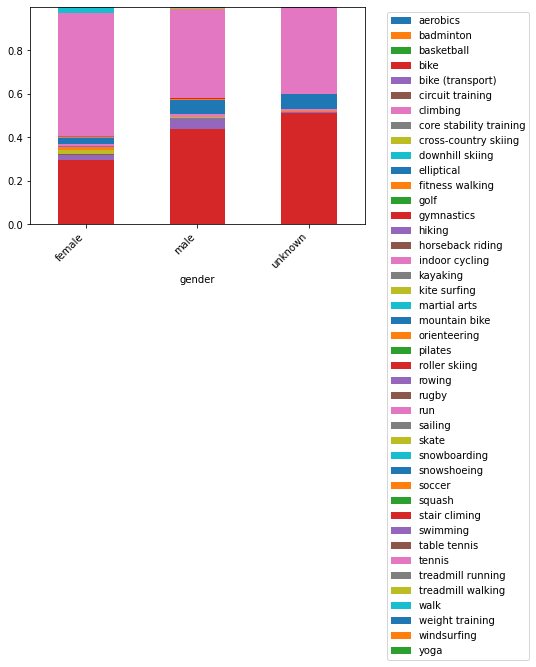

In [0]:
n_rows = 1
n_cols = 1

plt.figure(figsize=(14, 10))

#df_fitnessdata_meanspeed = df_fitnessdata_meanspeed.select('gender', 'sport').toPandas()

i = 0

# loop through categorical features
for c in sorted(['gender']):
    tmp_data = pd.crosstab(df_fitnessdata_meanspeed.loc[:, c], df_fitnessdata_meanspeed['sport'])

    tmp_data = tmp_data.apply(lambda x: x/tmp_data.sum(axis=1))
    ax = tmp_data.plot.bar(stacked=True, grid=False, legend=True)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    i += 1

fig.tight_layout(pad=1.5)

#### Correlation of the Time Series Channels

One interesting analysis is the visualization of the correlation between the heart_rate and mean_speed time series (as these will be mainly used for the classification task as they perform characteristic time-dependant curves). These plots are visible in the second `utils.ipynb` notebook.

### Dara Preparation

Before applying different classification approaches, we will first prepare our dataset and use our knowledge from the above data abalysis.

In [0]:
unneeded_cols = ['longitude', 'altitude', 'latitude', 'id', 'timestamp', 'url', 'userId', 'speed']

df_pandas = df_fitnessdata_meanspeed.drop(*unneeded_cols).toPandas()
df_pandas

Out[9]:

gender 
 heart_rate 
 mean_speed 
 sport 
 
 
 
 
 0 
 male 
 [100, 111, 120, 119, 120, 116, 125, 128, 131, ... 
 [0.0, 10.7608, 16.8063, 15.9143, 24.4485, 33.8... 
 bike 
 
 
 1 
 male 
 [100, 105, 111, 110, 108, 115, 126, 130, 132, ... 
 [0.0, 12.3437, 14.2799, 17.3248, 14.7507, 26.7... 
 bike 
 
 
 2 
 male 
 [99, 105, 113, 110, 109, 110, 108, 121, 116, 1... 
 [0.0, 7.7623, 16.2746, 18.1418, 22.3692, 33.67... 
 bike 
 
 
 3 
 male 
 [99, 105, 113, 109, 112, 116, 116, 114, 114, 1... 
 [0.0, 12.6255, 16.795, 20.1652, 23.4833, 26.23... 
 bike 
 
 
 4 
 male 
 [110, 113, 114, 116, 123, 126, 129, 135, 137, ... 
 [0.0, 12.9392, 17.2167, 24.2163, 22.6824, 22.8... 
 bike (transport) 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 167778 
 male 
 [98, 99, 99, 99, 99, 101, 103, 106, 111, 114, ... 
 [0.0, 7.0851, 12.2206, 16.1594, 17.3101, 17.66... 
 run 
 
 
 167779 
 male 
 [140, 139, 136, 135, 134, 134, 134, 136, 136, ... 
 [0.0, 4.6005, 8.3096, 9.4891, 10.7825, 10.2371... 
 bike 
 
 
 167780 
 male 
 [102, 102, 102, 109, 110, 117, 117, 119, 119, ... 
 [0.0, 11.8038, 16.7491, 18.0517, 17.3282, 18.7... 
 run 
 
 
 167781 
 male 
 [103, 106, 108, 107, 107, 107, 107, 109, 112, ... 
 [0.0, 11.0719, 21.2342, 18.0742, 8.8801, 10.85... 
 bike 
 
 
 167782 
 male 
 [139, 139, 140, 142, 144, 146, 148, 150, 151, ... 
 [0.0, 10.3434, 11.104, 11.8769, 11.438, 12.035... 
 run 
 
 
 
 167783 rows × 4 columns

#### Data Balancing via Downsampling

As we have to deal with the problem of a highly imbalanced dataset, these cells prepare two strategies to face this issue, downsampling (and later a sample weight approach).

In [0]:
########## IMPORTANT: This performs downsampling balancing here (if using the weight_sample approach, do not use this code section)! ##########

# these classes were determined above when counting all sport targets of the entire dataset (just redefined here to change the algorithm easier)
low_samples_classes = ['weight training', 'hiking', 'kayaking', 'elliptical', 'rowing', 'soccer', 'treadmill running', 'skate', 'tennis', 'gymnastics', 'circuit training', 'fitness walking', 'basketball', 'snowshoeing', 'yoga', 'swimming', 'snowboarding', 'roller skiing', 'horseback riding', 'downhill skiing', 'stair climing', 'golf', 'aerobics', 'badminton', 'treadmill walking', 'table tennis', 'pilates', 'kite surfing', 'sailing', 'climbing', 'squash', 'martial arts', 'windsurfing', 'rugby']
high_sampled_classes = ['mountain bike', 'bike (transport)', 'run', 'bike']

# keep_classes = ['weight training', 'mountain bike', 'cross-country skiing', 'hiking', 'kayaking', 'orienteering', 'rowing', 'soccer', 'bike (transport)', 'indoor cycling', 'walk', 'skate', 'run', 'core stability training', 'bike', 'gymnastics', 'circuit training', 'fitness walking', 'roller skiing', 'downhill skiing']

# facing class imbalance problem
sample_df_pandas_balancing = df_pandas
rare_class = 'rare'
maximum_sample_number = 2000
drop_indices = []

high_sampled_classes_counter  = {sport: 0 for sport in high_sampled_classes}

for index, row in df_pandas.iterrows():
    sport = row.sport
    
    # change label to rare class
    if sport in low_samples_classes:
        sample_df_pandas_balancing.at[index, 'sport'] = rare_class
        
    # limit number of samples to maximum
    elif sport in high_sampled_classes:
        counter = high_sampled_classes_counter[sport]
        
        # increment counter and save new counter into counter dict
        counter += 1
        high_sampled_classes_counter[sport] = counter
        
        if counter > maximum_sample_number:
            drop_indices.append(index)
    
# drop rows which were collected in drop_indices (as these are too highly sampled) -> cut off after maximum count is reached
sample_df_pandas_balancing = sample_df_pandas_balancing.drop(drop_indices).reset_index(drop=True)
sample_df_pandas_balancing

Out[10]:

gender 
 heart_rate 
 mean_speed 
 sport 
 
 
 
 
 0 
 male 
 [100, 111, 120, 119, 120, 116, 125, 128, 131, ... 
 [0.0, 10.7608, 16.8063, 15.9143, 24.4485, 33.8... 
 bike 
 
 
 1 
 male 
 [100, 105, 111, 110, 108, 115, 126, 130, 132, ... 
 [0.0, 12.3437, 14.2799, 17.3248, 14.7507, 26.7... 
 bike 
 
 
 2 
 male 
 [99, 105, 113, 110, 109, 110, 108, 121, 116, 1... 
 [0.0, 7.7623, 16.2746, 18.1418, 22.3692, 33.67... 
 bike 
 
 
 3 
 male 
 [99, 105, 113, 109, 112, 116, 116, 114, 114, 1... 
 [0.0, 12.6255, 16.795, 20.1652, 23.4833, 26.23... 
 bike 
 
 
 4 
 male 
 [110, 113, 114, 116, 123, 126, 129, 135, 137, ... 
 [0.0, 12.9392, 17.2167, 24.2163, 22.6824, 22.8... 
 bike (transport) 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 14793 
 male 
 [179, 178, 178, 178, 177, 177, 176, 176, 175, ... 
 [0.0, 5.2425, 4.8297, 8.2105, 5.9001, 4.6577, ... 
 walk 
 
 
 14794 
 male 
 [182, 181, 180, 178, 177, 176, 176, 175, 174, ... 
 [0.0, 2.7315, 3.6252, 1.2979, 9.986, 1.1929, 6... 
 walk 
 
 
 14795 
 male 
 [177, 177, 177, 177, 176, 175, 174, 173, 172, ... 
 [0.0, 5.1887, 6.175, 5.5124, 5.0031, 4.6883, 4... 
 walk 
 
 
 14796 
 male 
 [175, 175, 172, 169, 169, 169, 168, 168, 167, ... 
 [0.0, 4.2466, 4.972, 5.3656, 5.0906, 5.0671, 5... 
 walk 
 
 
 14797 
 male 
 [169, 169, 169, 169, 168, 168, 168, 167, 167, ... 
 [0.0, 26.9175, 5.2017, 5.2393, 5.0008, 4.433, ... 
 walk 
 
 
 
 14798 rows × 4 columns

In [0]:
# Visualize balancing process

# order display to receive the correct list of labels (need right order to visualize confusion matrix later)
sample_df_spark_balancing_countview = spark.createDataFrame(sample_df_pandas_balancing).groupBy("sport").count().orderBy(["count", "sport"], ascending=[0, 1])
sample_df_spark_balancing_countview.display()

label_list = sample_df_spark_balancing_countview.select("sport").rdd.flatMap(lambda x: x).collect()
print("New label list: {}".format(label_list))

sport count bike 2000 bike (transport) 2000 mountain bike 2000 run 2000 indoor cycling 1725 rare 1680 walk 1289 orienteering 867 cross-country skiing 789 core stability training 448

New label list: ['bike', 'bike (transport)', 'mountain bike', 'run', 'indoor cycling', 'rare', 'walk', 'orienteering', 'cross-country skiing', 'core stability training']

In [0]:
# needed to do not overwrite variable while implementing the algorithm idea
df_pandas = sample_df_pandas_balancing
# df_spark = spark.createDataFrame(df_pandas)
# df_spark.display()

## for demo: save df_pandas here and load it again later for the LSTM variants (to save time during the demo)
df_pandas.to_pickle('/tmp/DownsampledTimeseriesDataframe.pkl')
#dbutils.fs.cp("file:/tmp/DownsampledTimeseriesDataframe.pkl", "dbfs:/bdc-2020-21/tmp/DownsampledTimeseriesDataframe.pkl")  # uncomment if not needed
#dbutils.fs.cp("dbfs:/bdc-2020-21/tmp/DownsampledTimeseriesDataframe.pkl", "file:/tmp/DownsampledTimeseriesDataframeNEW.pkl")  # uncomment if not needed
df_pandas_loaded = pd.read_pickle('/tmp/DownsampledTimeseriesDataframeNEW.pkl')

df_pandas_loaded

Out[11]:

gender 
 heart_rate 
 mean_speed 
 sport 
 
 
 
 
 0 
 male 
 [100, 111, 120, 119, 120, 116, 125, 128, 131, ... 
 [0.0, 10.7608, 16.8063, 15.9143, 24.4485, 33.8... 
 bike 
 
 
 1 
 male 
 [100, 105, 111, 110, 108, 115, 126, 130, 132, ... 
 [0.0, 12.3437, 14.2799, 17.3248, 14.7507, 26.7... 
 bike 
 
 
 2 
 male 
 [99, 105, 113, 110, 109, 110, 108, 121, 116, 1... 
 [0.0, 7.7623, 16.2746, 18.1418, 22.3692, 33.67... 
 bike 
 
 
 3 
 male 
 [99, 105, 113, 109, 112, 116, 116, 114, 114, 1... 
 [0.0, 12.6255, 16.795, 20.1652, 23.4833, 26.23... 
 bike 
 
 
 4 
 male 
 [110, 113, 114, 116, 123, 126, 129, 135, 137, ... 
 [0.0, 12.9392, 17.2167, 24.2163, 22.6824, 22.8... 
 bike (transport) 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 14793 
 male 
 [179, 178, 178, 178, 177, 177, 176, 176, 175, ... 
 [0.0, 5.2425, 4.8297, 8.2105, 5.9001, 4.6577, ... 
 walk 
 
 
 14794 
 male 
 [182, 181, 180, 178, 177, 176, 176, 175, 174, ... 
 [0.0, 2.7315, 3.6252, 1.2979, 9.986, 1.1929, 6... 
 walk 
 
 
 14795 
 male 
 [177, 177, 177, 177, 176, 175, 174, 173, 172, ... 
 [0.0, 5.1887, 6.175, 5.5124, 5.0031, 4.6883, 4... 
 walk 
 
 
 14796 
 male 
 [175, 175, 172, 169, 169, 169, 168, 168, 167, ... 
 [0.0, 4.2466, 4.972, 5.3656, 5.0906, 5.0671, 5... 
 walk 
 
 
 14797 
 male 
 [169, 169, 169, 169, 168, 168, 168, 167, 167, ... 
 [0.0, 26.9175, 5.2017, 5.2393, 5.0008, 4.433, ... 
 walk 
 
 
 
 14798 rows × 4 columns

#### Data Balancing via Sample Weights

In [0]:
# redefine the count dictionary for faster calculation when running the notebook (was calculated before)
sample_weight_dict = {'weight training': 74, 'mountain bike': 10722, 'cross-country skiing': 789, 'hiking': 237, 'kayaking': 92, 'orienteering': 867, 'elliptical': 10, 'rowing': 71, 'soccer': 51, 'bike (transport)': 7757, 'indoor cycling': 1725, 'treadmill running': 28, 'walk': 1289, 'skate': 271, 'run': 70591, 'core stability training': 448, 'tennis': 8, 'bike': 71915, 'gymnastics': 66, 'circuit training': 89, 'fitness walking': 292, 'basketball': 8, 'snowshoeing': 16, 'yoga': 1, 'swimming': 14, 'snowboarding': 3, 'roller skiing': 238, 'horseback riding': 10, 'downhill skiing': 48, 'stair climing': 3, 'golf': 12, 'aerobics': 7, 'badminton': 10, 'treadmill walking': 1, 'table tennis': 4, 'pilates': 3, 'kite surfing': 1, 'sailing': 1, 'climbing': 5, 'squash': 1, 'martial arts': 1, 'windsurfing': 1, 'rugby': 3}

In [0]:
########## IMPORTANT: This performs sample weight balancing here (if using the downsampling approach, do not use this code section)! ##########

sample_df_pandas_balancing = df_pandas

# add sample weight as additional column to dataframe
sample_df_pandas_balancing['sample_weight'] = -42.0  # initialize sample weight column as double-> reset these values as a next step (have to this before labelindexing)

for index, row in sample_df_pandas_balancing.iterrows():   
    # set sample weight for each workout session
    sample_df_pandas_balancing.at[index, 'sample_weight'] = 1/sample_weight_dict[row.sport]  # set sample weight as inverse count number

In [0]:
df_pandas = sample_df_pandas_balancing
df_pandas

Out[7]:

gender 
 heart_rate 
 mean_speed 
 sport 
 sample_weight 
 
 
 
 
 0 
 male 
 [100, 111, 120, 119, 120, 116, 125, 128, 131, ... 
 [0.0, 10.7608, 16.8063, 15.9143, 24.4485, 33.8... 
 bike 
 0.000014 
 
 
 1 
 male 
 [100, 105, 111, 110, 108, 115, 126, 130, 132, ... 
 [0.0, 12.3437, 14.2799, 17.3248, 14.7507, 26.7... 
 bike 
 0.000014 
 
 
 2 
 male 
 [99, 105, 113, 110, 109, 110, 108, 121, 116, 1... 
 [0.0, 7.7623, 16.2746, 18.1418, 22.3692, 33.67... 
 bike 
 0.000014 
 
 
 3 
 male 
 [99, 105, 113, 109, 112, 116, 116, 114, 114, 1... 
 [0.0, 12.6255, 16.795, 20.1652, 23.4833, 26.23... 
 bike 
 0.000014 
 
 
 4 
 male 
 [110, 113, 114, 116, 123, 126, 129, 135, 137, ... 
 [0.0, 12.9392, 17.2167, 24.2163, 22.6824, 22.8... 
 bike (transport) 
 0.000129 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 167778 
 male 
 [98, 99, 99, 99, 99, 101, 103, 106, 111, 114, ... 
 [0.0, 7.0851, 12.2206, 16.1594, 17.3101, 17.66... 
 run 
 0.000014 
 
 
 167779 
 male 
 [140, 139, 136, 135, 134, 134, 134, 136, 136, ... 
 [0.0, 4.6005, 8.3096, 9.4891, 10.7825, 10.2371... 
 bike 
 0.000014 
 
 
 167780 
 male 
 [102, 102, 102, 109, 110, 117, 117, 119, 119, ... 
 [0.0, 11.8038, 16.7491, 18.0517, 17.3282, 18.7... 
 run 
 0.000014 
 
 
 167781 
 male 
 [103, 106, 108, 107, 107, 107, 107, 109, 112, ... 
 [0.0, 11.0719, 21.2342, 18.0742, 8.8801, 10.85... 
 bike 
 0.000014 
 
 
 167782 
 male 
 [139, 139, 140, 142, 144, 146, 148, 150, 151, ... 
 [0.0, 10.3434, 11.104, 11.8769, 11.438, 12.035... 
 run 
 0.000014 
 
 
 
 167783 rows × 5 columns

### TimeSeriesForest

A **TimeSeriesForest is a variant of a RandomForest** which is applicable to time series data. The main idea is to slice each fitness sample into **randomly cut subsamples and calculate time series features for each subsample**. For this, we will cut the subsamples equally for both channels (mean_speed and heart_rate). The calculated vector per has the following construction:

$$
\begin{bmatrix} speed_{mean} & speed_{std} & speed_{max} & heart_{mean} & heart_{std} & heart_{max} & gender \end{bmatrix}^T
$$

This will be our new feature vector structure. From each fitness sample, we will create this vector by choosing a random part of the original time series (specifications about the selection of each interval are given in the following code and text paragraohs).

Therefore, we will generate our new dataset for this task. This first code snippet calculates the mean, variance and maximum speed for both time series channels:

In [0]:
import random
import numpy as np

def get_mean_var_max_length_of_timeseries(sample):
    # split time series into random intervals and calculate the new features of it
    speed_series, heart_series = sample.mean_speed, sample.heart_rate
    sport = sample.sport
    gender = sample.gender
    
    subsequence_container = []
    
    length = len(speed_series)  # both series have equal length 
    current_step_in_series = 0
    
    # random length should be at least 50 and mostly 100 timesteps long 
    while current_step_in_series < length-50:
        random_end = random.randint(current_step_in_series+50, current_step_in_series+100)
        
        # ensure that last sequence is at least 50 timesteps long, otherwise skip it
        if random_end - current_step_in_series < 50:
            continue
        
        subsequence_speed = np.array(speed_series[current_step_in_series:random_end])
        subsequence_heart = np.array(heart_series[current_step_in_series:random_end])
             
        mean1, std1, maxval1 = np.mean(subsequence_speed), np.std(subsequence_speed), np.amax(subsequence_speed)
        mean2, std2, maxval2 = np.mean(subsequence_heart), np.std(subsequence_heart), np.amax(subsequence_heart)
        
        feature_vec = np.array((mean1, std1, maxval1, mean2, std2, maxval2, sport, gender))
        subsequence_container.append(feature_vec)
    
        current_step_in_series = random_end
      
    return subsequence_container

In [0]:
import pandas as pd

# build new dataframe to perform RandomForest for TimeSeries
total_sample_list = []

# loop through dataframe
for index, row in df_pandas.iterrows():
    total_sample_list.extend(get_mean_var_max_length_of_timeseries(row))

random_forest_features = pd.DataFrame(total_sample_list, columns = ['mean_speed', 'var_speed', 'max_speed', 'mean_heart', 'var_heart', 'max_heart', 'sport', 'gender'])

In [0]:
# cast to numerical values
numerical_columns = ['mean_speed', 'var_speed', 'max_speed', 'mean_heart', 'var_heart', 'max_heart']

for col in numerical_columns:
    random_forest_features[col] = pd.to_numeric(random_forest_features[col], downcast="float")

random_forest_features.dtypes

Out[9]: mean_speed float32
var_speed float32
max_speed float32
mean_heart float32
var_heart float32
max_heart float32
sport object
gender object
dtype: object

In [0]:
random_forest_features

Out[10]:

mean_speed 
 var_speed 
 max_speed 
 mean_heart 
 var_heart 
 max_heart 
 sport 
 gender 
 
 
 
 
 0 
 24.895386 
 5.970723 
 33.965000 
 141.603455 
 12.710218 
 163.0 
 bike 
 male 
 
 
 1 
 24.517075 
 7.863270 
 48.812099 
 152.337204 
 7.986341 
 169.0 
 bike 
 male 
 
 
 2 
 26.475359 
 6.441701 
 41.163502 
 155.451614 
 7.154991 
 173.0 
 bike 
 male 
 
 
 3 
 26.337736 
 7.921152 
 47.280800 
 151.623184 
 8.066933 
 166.0 
 bike 
 male 
 
 
 4 
 26.965019 
 9.503142 
 56.731701 
 157.860001 
 8.298217 
 174.0 
 bike 
 male 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 96403 
 5.037871 
 0.464539 
 6.248900 
 122.285713 
 2.273404 
 125.0 
 walk 
 male 
 
 
 96404 
 5.162115 
 0.586511 
 7.623400 
 118.776314 
 1.618956 
 122.0 
 walk 
 male 
 
 
 96405 
 4.772725 
 0.697567 
 6.372800 
 117.266670 
 1.600694 
 119.0 
 walk 
 male 
 
 
 96406 
 5.022465 
 0.549656 
 6.662300 
 115.147057 
 2.641661 
 120.0 
 walk 
 male 
 
 
 96407 
 4.607222 
 0.367738 
 5.719300 
 114.683334 
 1.117910 
 116.0 
 walk 
 male 
 
 
 
 96408 rows × 8 columns

In [0]:
## removing problematic rows with unnatural spikes in the data (e.g. running with over 100km/h)
indices_problematic_speeds = []

for index, row in random_forest_features.iterrows():
    max_speed = row.max_speed
    
    if max_speed > 100:
        indices_problematic_speeds.append(index)
    
print('Number of problematic speeds: {}'.format(len(indices_problematic_speeds)))

Number of problematic speeds: 907

In [0]:
random_forest_features_cleaned = random_forest_features.drop(indices_problematic_speeds).reset_index(drop=True)
random_forest_features_cleaned

Out[12]:

mean_speed 
 var_speed 
 max_speed 
 mean_heart 
 var_heart 
 max_heart 
 sport 
 gender 
 
 
 
 
 0 
 24.895386 
 5.970723 
 33.965000 
 141.603455 
 12.710218 
 163.0 
 bike 
 male 
 
 
 1 
 24.517075 
 7.863270 
 48.812099 
 152.337204 
 7.986341 
 169.0 
 bike 
 male 
 
 
 2 
 26.475359 
 6.441701 
 41.163502 
 155.451614 
 7.154991 
 173.0 
 bike 
 male 
 
 
 3 
 26.337736 
 7.921152 
 47.280800 
 151.623184 
 8.066933 
 166.0 
 bike 
 male 
 
 
 4 
 26.965019 
 9.503142 
 56.731701 
 157.860001 
 8.298217 
 174.0 
 bike 
 male 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 95496 
 5.037871 
 0.464539 
 6.248900 
 122.285713 
 2.273404 
 125.0 
 walk 
 male 
 
 
 95497 
 5.162115 
 0.586511 
 7.623400 
 118.776314 
 1.618956 
 122.0 
 walk 
 male 
 
 
 95498 
 4.772725 
 0.697567 
 6.372800 
 117.266670 
 1.600694 
 119.0 
 walk 
 male 
 
 
 95499 
 5.022465 
 0.549656 
 6.662300 
 115.147057 
 2.641661 
 120.0 
 walk 
 male 
 
 
 95500 
 4.607222 
 0.367738 
 5.719300 
 114.683334 
 1.117910 
 116.0 
 walk 
 male 
 
 
 
 95501 rows × 8 columns

In [0]:
def normalize_features(df, features_to_normalize):
    from sklearn.preprocessing import MinMaxScaler

    scalar = MinMaxScaler()
    
    # cast 2d numpy.array return of fit_transform to pd.DataFrame
    standardized_features = pd.DataFrame(scalar.fit_transform(df[features_to_normalize].copy()), columns = features_to_normalize)
    old_shape = df.shape
    
    # drop unnormalized features from the dataframe
    df.drop(features_to_normalize, axis=1, inplace=True)
    
    # join normalized features again
    df_joined = pd.concat([df, standardized_features], axis=1)
    
    assert old_shape == df_joined.shape, "Error while normalizing dataframe"
    
    return df_joined

In [0]:
# normalize data frame by column
random_forest_features_normalized = normalize_features(random_forest_features_cleaned, numerical_columns)
random_forest_features_normalized

Out[14]:

sport 
 gender 
 mean_speed 
 var_speed 
 max_speed 
 mean_heart 
 var_heart 
 max_heart 
 
 
 
 
 0 
 bike 
 male 
 0.309364 
 0.204878 
 0.339829 
 0.637977 
 0.049095 
 0.679167 
 
 
 1 
 bike 
 male 
 0.304663 
 0.269818 
 0.488378 
 0.686336 
 0.030848 
 0.704167 
 
 
 2 
 bike 
 male 
 0.328997 
 0.221039 
 0.411852 
 0.700368 
 0.027637 
 0.720833 
 
 
 3 
 bike 
 male 
 0.327287 
 0.271804 
 0.473057 
 0.683119 
 0.031160 
 0.691667 
 
 
 4 
 bike 
 male 
 0.335082 
 0.326088 
 0.567616 
 0.711218 
 0.032053 
 0.725000 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 95496 
 walk 
 male 
 0.062603 
 0.015940 
 0.062522 
 0.550943 
 0.008781 
 0.520833 
 
 
 95497 
 walk 
 male 
 0.064147 
 0.020125 
 0.076274 
 0.535132 
 0.006253 
 0.508333 
 
 
 95498 
 walk 
 male 
 0.059308 
 0.023936 
 0.063762 
 0.528330 
 0.006183 
 0.495833 
 
 
 95499 
 walk 
 male 
 0.062412 
 0.018861 
 0.066658 
 0.518781 
 0.010204 
 0.500000 
 
 
 95500 
 walk 
 male 
 0.057252 
 0.012618 
 0.057223 
 0.516691 
 0.004318 
 0.483333 
 
 
 
 95501 rows × 8 columns

In [0]:
# testing normalization result (mean_speed should become 1.0 now)
mean_speed = np.array(list(random_forest_features_normalized.mean_speed))
max_speed_idx = np.argmax(mean_speed)

random_forest_features_normalized.iloc[[max_speed_idx]]

Out[44]:

sport 
 gender 
 mean_speed 
 var_speed 
 max_speed 
 mean_heart 
 var_heart 
 max_heart 
 
 
 
 
 3208 
 bike 
 unknown 
 1.0 
 0.750817 
 0.991497 
 0.288707 
 0.018158 
 0.333333

In [0]:
df_spark_random_forest_features = spark.createDataFrame(random_forest_features_normalized)
df_spark_random_forest_features.display()

sport gender mean_speed var_speed max_speed mean_heart var_heart max_heart bike male 0.30936366 0.20487757 0.33982876 0.6379766 0.049094923 0.6791667 bike male 0.3046626 0.26981786 0.48837787 0.68633616 0.030848311 0.7041667 bike male 0.32899728 0.22103855 0.41185164 0.70036775 0.027637113 0.72083336 bike male 0.3272871 0.27180398 0.47305682 0.68311924 0.03115961 0.6916667 bike male 0.33508208 0.32608792 0.56761557 0.7112184 0.032052975 0.725 bike male 0.30525976 0.2886513 0.47225538 0.6874091 0.04401257 0.7375 bike male 0.33666745 0.22909465 0.42393598 0.6211179 0.04648945 0.65000004 bike male 0.3357884 0.21921225 0.4536396 0.65207785 0.030646808 0.67083335 bike male 0.33979556 0.2997445 0.48813576 0.69775003 0.024022158 0.71250004 bike male 0.31172135 0.33923215 0.5941665 0.6936648 0.047453273 0.725 bike male 0.3878098 0.30437034 0.52977765 0.6642704 0.0379377 0.68750006 bike male 0.30259848 0.20761108 0.41759562 0.65527004 0.030440666 0.67083335 bike male 0.29485947 0.18893658 0.33690518 0.59213495 0.04864597 0.65000004 bike male 0.30148235 0.26902843 0.45288524 0.6384832 0.031825196 0.675 bike male 0.3244423 0.28073466 0.41478917 0.61281437 0.029692642 0.63750005 bike male 0.35805172 0.2500203 0.49228695 0.6550036 0.031336535 0.67083335 bike male 0.33886796 0.32674518 0.59257466 0.64205164 0.042607937 0.6666667 bike male 0.30619502 0.2718316 0.3855868 0.6648918 0.04354011 0.70000005 bike male 0.3234809 0.22195973 0.41913748 0.6171586 0.038895067 0.68750006 bike male 0.33583504 0.25738028 0.4208724 0.6026689 0.048580036 0.6416667 bike male 0.34537655 0.210101 0.41171357 0.63186026 0.03626613 0.6541667 bike male 0.32346526 0.20561609 0.43920404 0.69099367 0.027586766 0.6958334 bike male 0.3674373 0.34773836 0.55697197 0.68409026 0.04317735 0.74166673 bike male 0.3259372 0.27986962 0.54445136 0.6717 0.036157444 0.68750006 bike male 0.3048185 0.3135542 0.45697236 0.6586739 0.033097517 0.6791667 bike male 0.30222464 0.14584516 0.32851082 0.6797239 0.02784541 0.6833334 bike (transport) male 0.38192046 0.30163798 0.44336018 0.67094034 0.051362906 0.70000005 bike (transport) male 0.41662094 0.24348316 0.505708 0.74959314 0.01229566 0.72083336 bike (transport) male 0.3186457 0.29661778 0.5167868 0.76910496 0.009622998 0.73333335 bike (transport) male 0.47755048 0.2313871 0.50948197 0.7460207 0.019845327 0.73333335 bike (transport) male 0.39132944 0.23268744 0.39991438 0.76789904 0.011756268 0.73333335 bike (transport) male 0.37704837 0.29395354 0.517075 0.794536 0.0094560245 0.76250005 bike (transport) male 0.2268451 0.21607807 0.28228948 0.5606606 0.03007902 0.58750004 bike (transport) male 0.27516246 0.26185235 0.31773412 0.6310376 0.0395365 0.675 bike (transport) male 0.23685886 0.31907856 0.3781629 0.72672737 0.036918063 0.7458334 bike (transport) male 0.25521764 0.37239146 0.5123725 0.63365245 0.032806795 0.65000004 bike (transport) male 0.35208035 0.29630765 0.4965752 0.7167977 0.024103934 0.7083334 bike (transport) male 0.29898205 0.23096043 0.3709271 0.7065202 0.034654837 0.73333335 bike (transport) male 0.34253958 0.24960573 0.38174677 0.62696224 0.036470592 0.65000004 bike (transport) male 0.41936234 0.30675998 0.53047603 0.7321234 0.014679182 0.6958334 bike (transport) male 0.3738894 0.24636456 0.45154253 0.75572294 0.012798687 0.72083336 bike (transport) male 0.2650008 0.14195305 0.29690418 0.78112745 0.01590705 0.7458334 bike (transport) male 0.41446096 0.25112185 0.47617647 0.74107486 0.02557959 0.7291667 bike (transport) male 0.39351562 0.15882058 0.39769617 0.7772723 0.017917443 0.75000006 bike (transport) male 0.361038 0.2180493 0.3980814 0.7946837 0.0223451 0.7708334 bike (transport) male 0.26521355 0.19376317 0.3102512 0.60036737 0.04426942 0.6291667 bike (transport) male 0.303512 0.20594752 0.40724722 0.66262794 0.035907824 0.68750006 bike (transport) male 0.22830291 0.25524613 0.39135984 0.70106846 0.0573882 0.7458334 bike (transport) male 0.29955882 0.36224422 0.51461965 0.6244115 0.04443129 0.675 bike (transp

In [0]:
RANDOM_SEED = 42
train_df, test_df = df_spark_random_forest_features.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

## for demo: save RandomForestFeatureDataset here and load it again later (to save time during the demo)
train_df.write.option('header', 'true').csv('/tmp/TimeSeriesForestFeatures_Dataset_withHeaders_TRAIN.csv')
test_df.write.option('header', 'true').csv('/tmp/TimeSeriesForestFeatures_Dataset_withHeaders_TEST.csv')

#### For Demo: read and load spark dataframe to save computation time

In [0]:
from pyspark.sql import functions as F

def cast_cols_to_float(df, cols=['mean_speed', 'var_speed', 'max_speed', 'mean_heart', 'var_heart', 'max_heart']):
    for col in cols:
        df = df.withColumn(col, F.col(col).cast('float'))
    
    return df

# reading csv into dataframe
train_df = spark.read.format('csv').option('header', 'true').load('/tmp/TimeSeriesForestFeatures_Dataset_withHeaders_TRAIN.csv')
test_df = spark.read.format('csv').option('header', 'true').load('/tmp/TimeSeriesForestFeatures_Dataset_withHeaders_TEST.csv')

# casting cols back to float
train_df = cast_cols_to_float(train_df)
test_df = cast_cols_to_float(test_df)

# show results
train_df.display()
test_df.display()

sport gender mean_speed var_speed max_speed mean_heart var_heart max_heart bike (transport) female 0.132158 0.050547514 0.1287097 0.6623518 0.015068724 0.6416667 bike (transport) female 0.13388392 0.060719687 0.12921496 0.58510363 0.03784621 0.5791667 bike (transport) female 0.13393152 0.07060373 0.13659985 0.6584647 0.014125544 0.6458334 bike (transport) female 0.13880943 0.031917855 0.13734624 0.6737004 0.015869444 0.67083335 bike (transport) female 0.15001416 0.06294864 0.15431918 0.66679543 0.046521023 0.6833334 bike (transport) female 0.15182829 0.050429907 0.15067226 0.71566147 0.022514991 0.70000005 bike (transport) female 0.15390478 0.10524715 0.20808345 0.6827802 0.04201269 0.72083336 bike (transport) male 0.001220061 0.012454602 0.014407579 0.54663503 0.022938453 0.5541667 bike (transport) male 0.00278996 0.01916398 0.021611368 0.59432185 0.021626418 0.5833334 bike (transport) male 0.0032858404 0.008807065 0.010805684 0.60435253 0.06814879 0.6458334 bike (transport) male 0.003328711 0.009084371 0.010085305 0.58417267 0.07452222 0.6416667 bike (transport) male 0.005069585 0.03287322 0.084496446 0.66627556 0.057505336 0.6791667 bike (transport) male 0.0050857277 0.02347984 0.021611368 0.57142377 0.020001486 0.5833334 bike (transport) male 0.0070487713 0.031958193 0.04516876 0.46705714 0.02045072 0.47500002 bike (transport) male 0.008157567 0.023412814 0.028238853 0.622541 0.07402514 0.65000004 bike (transport) male 0.012067042 0.05768397 0.07447417 0.53219736 0.06714154 0.57500005 bike (transport) male 0.012864906 0.05060814 0.06321025 0.47447225 0.019768994 0.48333335 bike (transport) male 0.021796014 0.06017386 0.09112893 0.67932034 0.029338632 0.6916667 bike (transport) male 0.023890568 0.19400764 0.3150197 0.4606209 0.022926295 0.5208334 bike (transport) male 0.026083535 0.23229991 0.349859 0.52691764 0.044000715 0.5625 bike (transport) male 0.032455493 0.25007877 0.3062901 0.5129047 0.06410322 0.59583336 bike (transport) male 0.038831044 0.12337038 0.18947166 0.6465212 0.06786924 0.72083336 bike (transport) male 0.039762404 0.12489149 0.15748483 0.6543394 0.04181919 0.6958334 bike (transport) male 0.040854897 0.1044568 0.114216074 0.6848725 0.03223433 0.70000005 bike (transport) male 0.040870313 0.09762338 0.1167384 0.6481926 0.021600958 0.6333334 bike (transport) male 0.04494512 0.17541255 0.18086714 0.5773505 0.04084748 0.6166667 bike (transport) male 0.04498447 0.22727735 0.23939592 0.35610014 0.04860617 0.36666667 bike (transport) male 0.052848097 0.15965034 0.15774296 0.5221072 0.015599394 0.51250005 bike (transport) male 0.052932594 0.101509854 0.16634749 0.66684335 0.06335065 0.74166673 bike (transport) male 0.053643357 0.1352771 0.15937483 0.5457466 0.026850369 0.53333336 bike (transport) male 0.057539 0.12555434 0.14507131 0.76109755 0.025790554 0.7458334 bike (transport) male 0.058359485 0.14903533 0.19404007 0.6904835 0.024139851 0.68750006 bike (transport) male 0.062143423 0.123175465 0.14744955 0.7630817 0.024863325 0.75000006 bike (transport) male 0.062159482 0.11851486 0.16807841 0.69704574 0.048778497 0.725 bike (transport) male 0.0687146 0.19768041 0.15300548 0.5923422 0.03808808 0.59583336 bike (transport) male 0.06960812 0.15320411 0.19554286 0.7113777 0.04141388 0.73333335 bike (transport) male 0.074177906 0.16484283 0.17478493 0.7682307 0.04278264 0.78333336 bike (transport) male 0.07445119 0.3608561 0.46306157 0.41867214 0.001003081 0.38750002 bike (transport) male 0.07981511 0.2950847 0.3545335 0.46274766 0.039621726 0.5541667 bike (transport) male 0.0805972 0.12773134 0.16359805 0.8011543 0.019771693 0.78333336 bike (transport) male 0.08286677 0.15358621 0.2639178 0.71017075 0.04990135 0.74166673 bike (transport) male 0.08575366 0.3266238 0.28886792 0.63510597 0.053554945 0.67083335 bike (transport) male 0.09006236 0.29867324 0.36439967 0.46048328 0.013409107 0.43333337 bike (transport) male 0.0949877 0.23848882 0.22390978 0.4288355 0.033280145 0.4666667 bike (transport) male 0.096978776 0.

sport gender mean_speed var_speed max_speed mean_heart var_heart max_heart bike (transport) male 0.029179206 0.06585523 0.10441592 0.5406924 0.057580583 0.6458334 bike (transport) male 0.11087732 0.031640258 0.10305521 0.7404388 0.019622194 0.7166667 bike (transport) male 0.12265394 0.19031619 0.20623347 0.47320735 0.011432938 0.46250004 bike (transport) male 0.13425691 0.26368573 0.2342182 0.48722407 0.064251505 0.5291667 bike (transport) male 0.14236785 0.27782303 0.24348706 0.42907065 0.062454727 0.5083334 bike (transport) male 0.14360736 0.23903607 0.28185824 0.7369878 0.046157166 0.7791667 bike (transport) male 0.15395528 0.12838864 0.19819924 0.6469545 0.060204215 0.6791667 bike (transport) male 0.15699962 0.13915564 0.2298259 0.62730443 0.041026242 0.6625 bike (transport) male 0.15790343 0.23735763 0.30445415 0.0 0.0 0.0 bike (transport) male 0.16197588 0.33518353 0.31704175 0.4815552 0.03343126 0.55833334 bike (transport) male 0.16406485 0.25866905 0.3537531 0.0 0.0 0.0 bike (transport) male 0.1642194 0.26605043 0.27330375 0.7399415 0.027233444 0.74166673 bike (transport) male 0.16549222 0.0780554 0.18055798 0.6157787 0.042548016 0.6333334 bike (transport) male 0.16800176 0.17143658 0.20208229 0.0 0.0 0.0 bike (transport) male 0.16857743 0.05234497 0.17543228 0.0 0.0 0.0 bike (transport) male 0.1733439 0.19471012 0.29214266 0.0 0.0 0.0 bike (transport) male 0.17662272 0.1596736 0.21841088 0.65587854 0.02860944 0.6625 bike (transport) male 0.17757335 0.22535528 0.26056704 0.0 0.0 0.0 bike (transport) male 0.18035872 0.216576 0.29490313 0.0 0.0 0.0 bike (transport) male 0.18144402 0.19069292 0.23949496 0.6791693 0.03309912 0.6791667 bike (transport) male 0.18230541 0.10047188 0.21053073 0.63089323 0.035361886 0.65000004 bike (transport) male 0.18264876 0.101835504 0.2142487 0.6569265 0.025960254 0.65833336 bike (transport) male 0.18291129 0.27435604 0.3530977 0.0 0.0 0.0 bike (transport) male 0.18635154 0.20338526 0.2584089 0.48700726 0.034815952 0.53333336 bike (transport) male 0.1868338 0.107633494 0.21717523 0.66919345 0.036786508 0.6791667 bike (transport) male 0.18993858 0.15846393 0.24281971 0.6680308 0.024568623 0.67083335 bike (transport) male 0.19009906 0.1242203 0.2446887 0.6407591 0.032230392 0.65833336 bike (transport) male 0.1909481 0.2514047 0.387795 0.0 0.0 0.0 bike (transport) male 0.19171387 0.33932808 0.34480035 0.5450726 0.019780248 0.5375 bike (transport) male 0.1919272 0.18395911 0.25253582 0.5115209 0.046517797 0.65833336 bike (transport) male 0.19228184 0.21474262 0.26940972 0.4960918 0.025795562 0.5083334 bike (transport) male 0.19435708 0.19243437 0.23946595 0.0 0.0 0.0 bike (transport) male 0.19441122 0.1354038 0.28892297 0.63440174 0.029858412 0.6541667 bike (transport) male 0.19515495 0.15412216 0.28448263 0.634844 0.034917027 0.6625 bike (transport) male 0.19555889 0.24591093 0.29133323 0.0 0.0 0.0 bike (transport) male 0.19571526 0.13610275 0.25335225 0.61960274 0.0428979 0.65833336 bike (transport) male 0.19575979 0.281122 0.27328676 0.0 0.0 0.0 bike (transport) male 0.19585203 0.2279526 0.29442987 0.5197612 0.044904567 0.6 bike (transport) male 0.19606401 0.18656895 0.22191374 0.6193157 0.042204823 0.6541667 bike (transport) male 0.19615953 0.14889097 0.2728295 0.605806 0.05702972 0.60833335 bike (transport) male 0.19647673 0.24193664 0.27107558 0.42196926 0.04157284 0.4916667 bike (transport) male 0.19714743 0.1521 0.24202429 0.6377808 0.033878274 0.6625 bike (transport) male 0.19718657 0.2796995 0.30479032 0.5711541 0.04453188 0.6541667 bike (transport) male 0.19759025 0.18976465 0.26415494 0.62657213 0.06978852 0.7375 bike (transport) male 0.19896144 0.31283024 0.45437798 0.5715245 0.080380484 0.6833334 bike (transport) male 0.19974999 0.1821998 0.2616036 0.6123947 0.032770872 0.63750005 bike (transport) male 0.2014789 0.28455594 0.34673136 0.5993435 0.037392505 0.63750005 bike (transport) male 0.20150779 0.106327154 0.23356085 0.67496794 0.04032068 0.675 bike (transport) male 0.2021991

In [0]:
def random_forest_pipeline(train, target='sport', 
                           numerical_features=['mean_speed', 'var_speed', 'max_speed', 'mean_heart', 'var_heart', 'max_heart'], 
                           categorical_features=['gender'], with_std=True, with_mean=True, k_fold=5):

    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.classification import RandomForestClassifier
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    from pyspark.ml import Pipeline
    
    # Indexing the categorical values
    indexers = [StringIndexer(inputCol=c, outputCol='{0}_indexed'.format(c), handleInvalid='keep') for c in categorical_features]

    # Indexing the target value (=given sport type)
    label_indexer = StringIndexer(inputCol = target, outputCol = 'label')
    
    assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers] + numerical_features, outputCol='features')

    # Combine all the preprocessing steps together
    stages = indexers + [label_indexer] + [assembler]

    # Create random forest transformer
    rf = RandomForestClassifier(featuresCol='features', labelCol='label')

    # Add RandomRorest to stages and finally build pipeline
    stages += [rf]
    pipeline = Pipeline(stages=stages)
    
    # Hyperparameter search via ParamGridBuilder
    param_grid = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [5, 8, 12]) \
    .addGrid(rf.numTrees, [10, 25, 40]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=MulticlassClassificationEvaluator(metricName='weightedPrecision'),
                               numFolds=k_fold,
                               collectSubModels=True # flag allows to store all models trained during k-fold cross validation
                               )

    # Do cross-validation  and choose the best set of parameters
    cv_model = cross_val.fit(train)

    return cv_model

In [0]:
cv_model = random_forest_pipeline(train_df)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
### save model via MLReader
cv_model.write().save('/tmp/TimeSeriesForest_downsampledData_NEW_mlreader_saved')

In [0]:
### for demo: laod model here
### load model via MLReader
from pyspark.ml.tuning import CrossValidatorModel
model_loaded = CrossValidatorModel.load('/tmp/TimeSeriesForest_downsampledData_NEW_mlreader_saved')

In [0]:
# ### load model via MLReader (same comment, just for checking if loading works)
# from pyspark.ml.tuning import CrossValidatorModel
# model_loaded = CrossValidatorModel.load('/tmp/TimeSeriesForest_downsampledData_NEW_mlreader_saved')

In [0]:
# test command to check successful model loading (command is part of the evaluation section underneath)

for i, weighted_precision in enumerate(model_loaded.avgMetrics):
    print("Weighted precision computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, weighted_precision))

Weighted precision computed across k-fold cross validation for model setting #1: 0.548
Weighted precision computed across k-fold cross validation for model setting #2: 0.554
Weighted precision computed across k-fold cross validation for model setting #3: 0.554
Weighted precision computed across k-fold cross validation for model setting #4: 0.616
Weighted precision computed across k-fold cross validation for model setting #5: 0.620
Weighted precision computed across k-fold cross validation for model setting #6: 0.622
Weighted precision computed across k-fold cross validation for model setting #7: 0.642
Weighted precision computed across k-fold cross validation for model setting #8: 0.651
Weighted precision computed across k-fold cross validation for model setting #9: 0.651

#### Evaluation of TimeSeriesForest

We have now trained our TimeSeriesForest! The following steps guide us through the evaluation of our trained classifier. As we have a multiclass classification problem, we will stick to common multiclass metrics such as accuracy, F1 score, and weighted and per class precision and recall.

In [0]:
### only overwrite variable if output of cells should be overwritten too
cv_model = model_loaded

In [0]:
for i, weighted_precision in enumerate(cv_model.avgMetrics):
    print("Weighted precision computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, weighted_precision))

Weighted precision computed across k-fold cross validation for model setting #1: 0.548
Weighted precision computed across k-fold cross validation for model setting #2: 0.554
Weighted precision computed across k-fold cross validation for model setting #3: 0.554
Weighted precision computed across k-fold cross validation for model setting #4: 0.616
Weighted precision computed across k-fold cross validation for model setting #5: 0.620
Weighted precision computed across k-fold cross validation for model setting #6: 0.622
Weighted precision computed across k-fold cross validation for model setting #7: 0.642
Weighted precision computed across k-fold cross validation for model setting #8: 0.651
Weighted precision computed across k-fold cross validation for model setting #9: 0.651

In [0]:
print("Best model according to k-fold cross validation: maxDept=[{:d}]".
      format(cv_model.bestModel.stages[-1]._java_obj.getMaxDepth(), 
             )
      )
print(cv_model.bestModel.stages[-1])

Best model according to k-fold cross validation: maxDept=[12]
RandomForestClassificationModel: uid=RandomForestClassifier_fd3145718252, numTrees=25, numClasses=10, numFeatures=7

In [0]:
### Summarize model performance on training set (BUT: saved model has no training summary available -> RuntimeError: No training summary available for this RandomForestClassificationModel)
#training_result = cv_model.bestModel.stages[-1].summary
print("***** Training Set *****")
print("Weighted precision: {:.3f}".format(training_result.weightedPrecision))

--------------------------------------------------------------------------- 
 RuntimeError Traceback (most recent call last)
 <command-3955852603314525> in <module> 
 1 ### Summarize model performance on training set (BUT: saved model has no training summary available -> RuntimeError: No training summary available for this RandomForestClassificationModel) 
 ----> 2 training_result = cv_model . bestModel . stages [ - 1 ] . summary
 3 print ( "***** Training Set *****" ) 
 4 print ( "Weighted precision: {:.3f}" . format ( training_result . weightedPrecision ) ) 

 /databricks/spark/python/pyspark/ml/classification.py in summary (self) 
 1855 super(RandomForestClassificationModel, self).summary)
 1856 else : 
 -> 1857 raise RuntimeError("No training summary available for this %s" %
 1858 self.__class__.__name__)
 1859 

 RuntimeError : No training summary available for this RandomForestClassificationModel

In [0]:
# Make predictions on test set
test_predictions = cv_model.transform(test_df)
test_predictions.display()

sport gender mean_speed var_speed max_speed mean_heart var_heart max_heart gender_indexed label features rawPrediction probability prediction bike (transport) male 0.029179206 0.06585523 0.10441592 0.5406924 0.057580583 0.6458334 0.0 3.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 0.029179206117987633, 0.0658552274107933, 0.10441592335700989, 0.5406923890113831, 0.05758058279752731, 0.6458333730697632)) Map(vectorType -> dense, length -> 10, values -> List(0.48817355128958867, 0.3454579868052124, 0.10229403472042864, 0.11967743168520856, 17.28772384345909, 4.6881898988245485, 0.2656967888436189, 0.035211267605633804, 0.16996572599541593, 1.4976094707712517)) Map(vectorType -> dense, length -> 10, values -> List(0.01952694205158355, 0.013818319472208497, 0.004091761388817146, 0.004787097267408343, 0.6915089537383637, 0.18752759595298196, 0.010627871553744759, 0.0014084507042253524, 0.006798629039816638, 0.05990437883085008)) 4.0 bike (transport) male 0.11087732 0.031640258 0.10305521 0.7404388 0.019622194 0.7166667 0.0 3.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 0.11087732017040253, 0.03164025768637657, 0.1030552089214325, 0.7404388189315796, 0.0196221936494112, 0.7166666984558105)) Map(vectorType -> dense, length -> 10, values -> List(0.018403041825095057, 0.7181165215556159, 12.059025397424564, 1.5597904079852825, 3.4980112230379206, 2.103566034018584, 1.305095362713046, 1.9403948367193022, 0.9410905225351426, 0.8565066521854424)) Map(vectorType -> dense, length -> 10, values -> List(7.361216730038025E-4, 0.028724660862224645, 0.4823610158969827, 0.062391616319411314, 0.13992044892151687, 0.0841426413607434, 0.05220381450852185, 0.0776157934687721, 0.03764362090140572, 0.03426026608741771)) 2.0 bike (transport) male 0.12265394 0.19031619 0.20623347 0.47320735 0.011432938 0.46250004 0.0 3.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 0.12265393882989883, 0.19031618535518646, 0.20623347163200378, 0.47320735454559326, 0.011432938277721405, 0.46250003576278687)) Map(vectorType -> dense, length -> 10, values -> List(2.155285889847245, 2.243564696061702, 0.03435437860785379, 13.327404909007464, 0.6321965315190027, 2.243990097306558, 1.9044837562271681, 0.038814814814814816, 2.1025773924008546, 0.317327534207337)) Map(vectorType -> dense, length -> 10, values -> List(0.0862114355938898, 0.08974258784246808, 0.0013741751443141518, 0.5330961963602986, 0.025287861260760106, 0.08975960389226233, 0.07617935024908673, 0.0015525925925925926, 0.08410309569603419, 0.01269310136829348)) 3.0 bike (transport) male 0.13425691 0.26368573 0.2342182 0.48722407 0.064251505 0.5291667 0.0 3.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 0.13425691425800323, 0.2636857330799103, 0.23421819508075714, 0.4872240722179413, 0.06425150483846664, 0.5291666984558105)) Map(vectorType -> dense, length -> 10, values -> List(6.272461475294374, 3.0158028597330855, 0.36776344654612175, 3.2079586518187155, 0.6348661924250368, 5.557317526978794, 0.17323291223739262, 0.26397181104667383, 5.0535605876027505, 0.4530645363170568)) Map(vectorType -> dense, length -> 10, values -> List(0.250898459011775, 0.12063211438932342, 0.01471053786184487, 0.1283183460727486, 0.025394647697001473, 0.22229270107915178, 0.006929316489495705, 0.010558872441866953, 0.20214242350411002, 0.018122581452682272)) 0.0 bike (transport) male 0.14236785 0.27782303 0.24348706 0.42907065 0.062454727 0.5083334 0.0 3.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 0.14236785471439362, 0.2778230309486389, 0.24348706007003784, 0.4290706515312195, 0.06245472654700279, 0.5083333849906921)) Map(vectorType -> dense, length -> 10, values -> List(6.883585603256939, 2.5651132396678116, 0.12855198304605414, 4.84328215040906, 0.19574757952669808, 6.87823632166973, 0.2505044785500548, 0.13184739708196794, 2.7485477811962107, 0.3745834655954735)) Map(vectorType -> dense, length -> 10, values -> List(0.2753434241302775, 0.10260452958671244, 0.005

In [0]:
def evaluate_model(predictions, metric="weightedPrecision"):
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    
    evaluator = MulticlassClassificationEvaluator(metricName=metric)

    return evaluator.evaluate(predictions)
  
  
def get_accuracy_matrix(predictionlabels):
    from pyspark.mllib.evaluation import MulticlassMetrics
    
    predictionlabels_rdd = predictionlabels.select("prediction", "label").rdd
    labels = predictionlabels_rdd.map(lambda lp: lp.label)
    
    metrics = MulticlassMetrics(predictionlabels_rdd)
    
    # Statistics by class
    labels = labels.distinct().collect()
    
    for label in sorted(labels):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    
    cm = metrics.confusionMatrix()
    
    return cm.toArray()

In [0]:
# command for demo (compare with original result below, keep possible other train/test split in mind)

print("***** Test Set *****")
print("Weighted precision: {:.3f}".format(evaluate_model(test_predictions)))
print("Weighted Recall: {:.3f}".format(evaluate_model(test_predictions, metric="weightedRecall")))
print("Weighted F1: {:.3f}".format(evaluate_model(test_predictions, metric="weightedFMeasure")))
print("Weighted False Positive Rate: {:.3f}".format(evaluate_model(test_predictions, metric="weightedFalsePositiveRate")))
print("Accuracy: {:.3f}".format(evaluate_model(test_predictions, metric="accuracy")))

***** Test Set *****
Weighted precision: 0.655
Weighted Recall: 0.656
Weighted F1: 0.643
Weighted False Positive Rate: 0.047
Accuracy: 0.656

In [0]:
print("***** Test Set *****")
print("Weighted precision: {:.3f}".format(evaluate_model(test_predictions)))
print("Weighted Recall: {:.3f}".format(evaluate_model(test_predictions, metric="weightedRecall")))
print("Weighted F1: {:.3f}".format(evaluate_model(test_predictions, metric="weightedFMeasure")))
print("Weighted False Positive Rate: {:.3f}".format(evaluate_model(test_predictions, metric="weightedFalsePositiveRate")))
print("Accuracy: {:.3f}".format(evaluate_model(test_predictions, metric="accuracy")))

***** Test Set *****
Weighted precision: 0.655
Weighted Recall: 0.656
Weighted F1: 0.643
Weighted False Positive Rate: 0.047
Accuracy: 0.656

Class 0.0 precision = 0.4811657959857025
Class 0.0 recall = 0.6857366771159875
Class 0.0 F1 Measure = 0.565519470027468
Class 1.0 precision = 0.6628175519630485
Class 1.0 recall = 0.6752941176470588
Class 1.0 F1 Measure = 0.6689976689976689
Class 2.0 precision = 0.7999285459092533
Class 2.0 recall = 0.8698523698523698
Class 2.0 F1 Measure = 0.8334263912153359
Class 3.0 precision = 0.5769230769230769
Class 3.0 recall = 0.48406374501992033
Class 3.0 F1 Measure = 0.5264298093587522
Class 4.0 precision = 0.8521281263712155
Class 4.0 recall = 0.8863532633500685
Class 4.0 F1 Measure = 0.8689038031319912
Class 5.0 precision = 0.5870165745856354
Class 5.0 recall = 0.3890160183066362
Class 5.0 F1 Measure = 0.4679328378750344
Class 6.0 precision = 0.7289187790998448
Class 6.0 recall = 0.8549757281553398
Class 6.0 F1 Measure = 0.786931024853393
Class 7.0 precision = 0.6149341142020498
Class 7.0 recall = 0.7440212577502214
Class 7.0 F1 Measure = 0.6733466933867737
Class 8.0 precision = 0.5664939550949913
Class 8.0 recall = 0.332994923857868
Class 8.0 F1 Measure = 0.4194373401534527
Class 9.0 precision = 0.6015037593984962
Class 9.0 recall = 0.1444043321299639
Class 9.0 F1 Measure = 0.2328966521106259

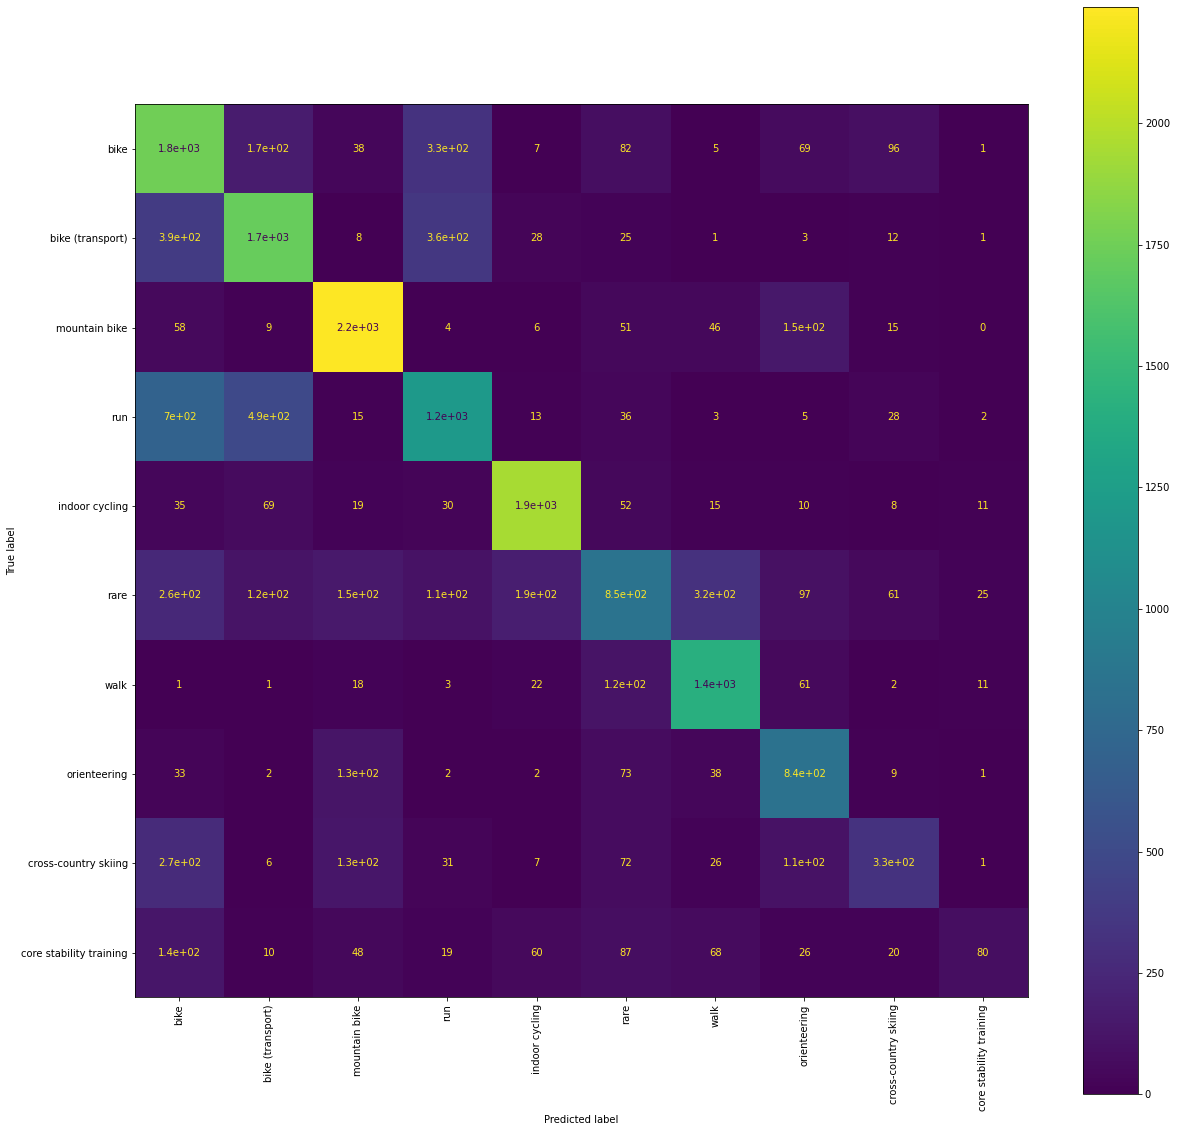

In [0]:
# command for demo (compare with original result, keep possible other train/test split in mind)

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = get_accuracy_matrix(test_predictions)

nr_labels = cm.shape[0]

ls = ['bike', 'bike (transport)', 'mountain bike', 'run', 'indoor cycling', 'rare', 'walk', 'orienteering', 'cross-country skiing', 'core stability training'] # list(range(nr_labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)

fig, ax = plt.subplots(figsize=(20,20))
disp.plot(ax=ax, xticks_rotation='vertical')

plt.show()

Class 0.0 precision = 0.49292807703882036
Class 0.0 recall = 0.6448818897637796
Class 0.0 F1 Measure = 0.5587583148558758
Class 1.0 precision = 0.6360555743815656
Class 1.0 recall = 0.7352134743439092
Class 1.0 F1 Measure = 0.6820494186046512
Class 2.0 precision = 0.8217228464419476
Class 2.0 recall = 0.8493999225706543
Class 2.0 F1 Measure = 0.8353321911288787
Class 3.0 precision = 0.5704960835509139
Class 3.0 recall = 0.5237714742309229
Class 3.0 F1 Measure = 0.5461362216204958
Class 4.0 precision = 0.8514460999123575
Class 4.0 recall = 0.881578947368421
Class 4.0 F1 Measure = 0.8662505572893446
Class 5.0 precision = 0.564845292955892
Class 5.0 recall = 0.3921389396709324
Class 5.0 F1 Measure = 0.4629080118694362
Class 6.0 precision = 0.728494623655914
Class 6.0 recall = 0.8267236119585113
Class 6.0 F1 Measure = 0.7745070020005717
Class 7.0 precision = 0.6006993006993007
Class 7.0 recall = 0.7615248226950354
Class 7.0 F1 Measure = 0.671618451915559
Class 8.0 precision = 0.5790697674418605
Class 8.0 recall = 0.2548618219037871
Class 8.0 F1 Measure = 0.3539445628997867
Class 9.0 precision = 0.6173913043478261
Class 9.0 recall = 0.1261101243339254
Class 9.0 F1 Measure = 0.2094395280235988

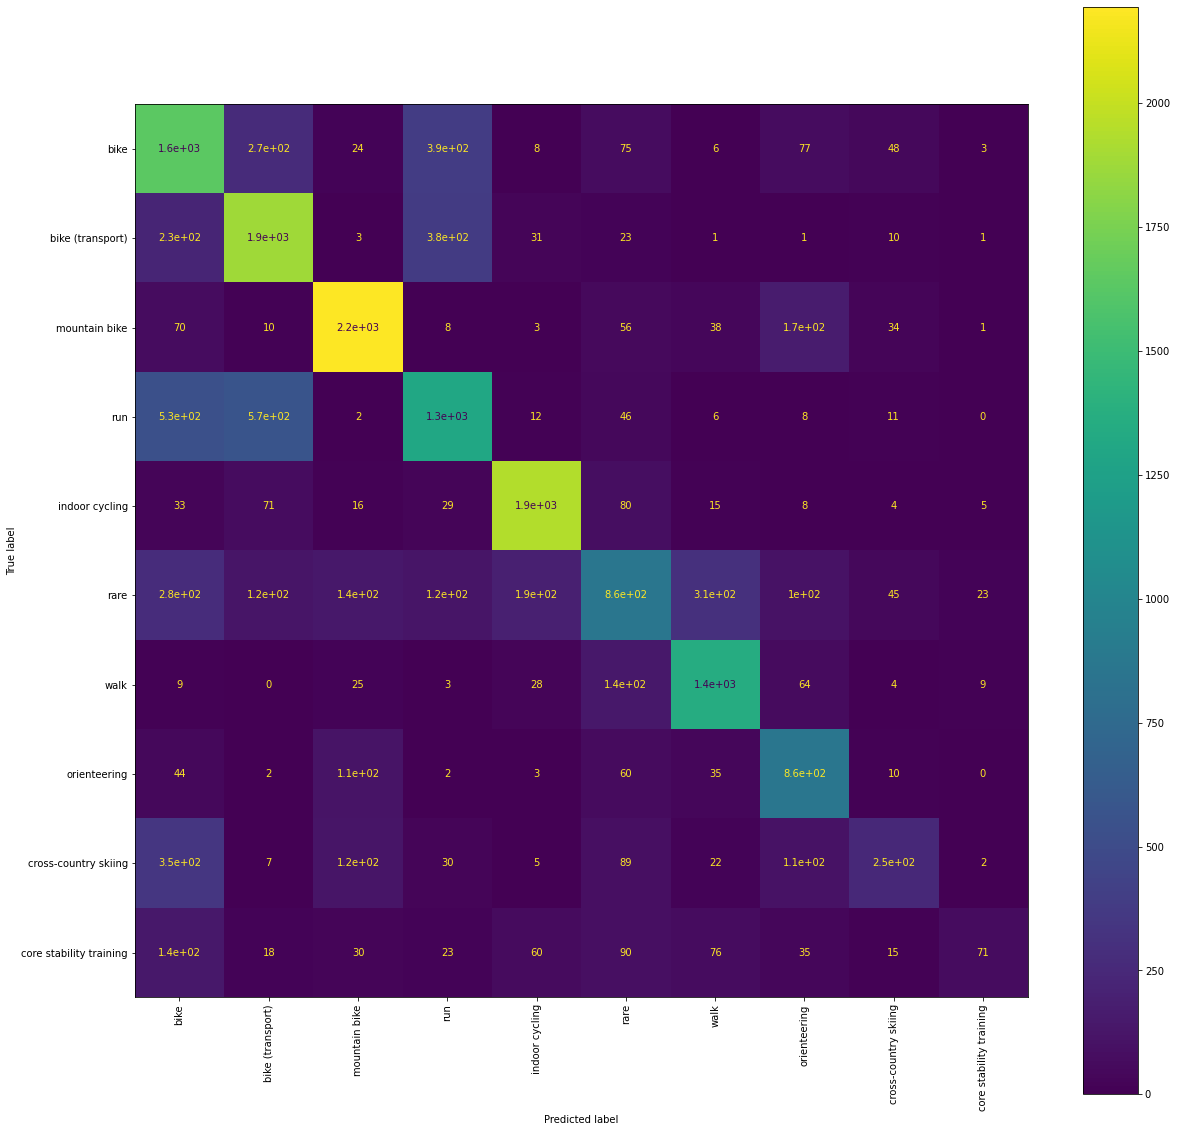

In [0]:
# first confusion matrix (from other train/test split)

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = get_accuracy_matrix(test_predictions)

nr_labels = cm.shape[0]

ls = ['bike', 'bike (transport)', 'mountain bike', 'run', 'indoor cycling', 'rare', 'walk', 'orienteering', 'cross-country skiing', 'core stability training'] # list(range(nr_labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)

fig, ax = plt.subplots(figsize=(20,20))
disp.plot(ax=ax, xticks_rotation='vertical')

plt.show()

These are the results of the evaluation step of our TimeSeriesForest. For deep-diving into the evaluation, refer to my presentation slides.

### LSTM classification

The LSTM training approach is divided into two parts, the first one deals with training an LSTM layer on the entire FitRec dataset using the sample weight approach to face the imbalanced classes problem. The second variant trains the LSTM architecture with the same downsampled dataset as used before for the TimeSeriesForest.

In [0]:
## for demo: load raw time series via pickle (named differently first to tackle overwriting issues during the training process)

dbutils.fs.cp("dbfs:/bdc-2020-21/tmp/DownsampledTimeseriesDataframe.pkl", "file:/tmp/DownsampledTimeseriesDataframeNEW.pkl")  # uncomment if not needed
df_pandas_loaded = pd.read_pickle('/tmp/DownsampledTimeseriesDataframeNEW.pkl')
df_pandas = df_pandas_loaded
df_pandas

Out[7]:

gender 
 heart_rate 
 mean_speed 
 sport 
 
 
 
 
 0 
 male 
 [100, 111, 120, 119, 120, 116, 125, 128, 131, ... 
 [0.0, 10.7608, 16.8063, 15.9143, 24.4485, 33.8... 
 bike 
 
 
 1 
 male 
 [100, 105, 111, 110, 108, 115, 126, 130, 132, ... 
 [0.0, 12.3437, 14.2799, 17.3248, 14.7507, 26.7... 
 bike 
 
 
 2 
 male 
 [99, 105, 113, 110, 109, 110, 108, 121, 116, 1... 
 [0.0, 7.7623, 16.2746, 18.1418, 22.3692, 33.67... 
 bike 
 
 
 3 
 male 
 [99, 105, 113, 109, 112, 116, 116, 114, 114, 1... 
 [0.0, 12.6255, 16.795, 20.1652, 23.4833, 26.23... 
 bike 
 
 
 4 
 male 
 [110, 113, 114, 116, 123, 126, 129, 135, 137, ... 
 [0.0, 12.9392, 17.2167, 24.2163, 22.6824, 22.8... 
 bike (transport) 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 14793 
 male 
 [179, 178, 178, 178, 177, 177, 176, 176, 175, ... 
 [0.0, 5.2425, 4.8297, 8.2105, 5.9001, 4.6577, ... 
 walk 
 
 
 14794 
 male 
 [182, 181, 180, 178, 177, 176, 176, 175, 174, ... 
 [0.0, 2.7315, 3.6252, 1.2979, 9.986, 1.1929, 6... 
 walk 
 
 
 14795 
 male 
 [177, 177, 177, 177, 176, 175, 174, 173, 172, ... 
 [0.0, 5.1887, 6.175, 5.5124, 5.0031, 4.6883, 4... 
 walk 
 
 
 14796 
 male 
 [175, 175, 172, 169, 169, 169, 168, 168, 167, ... 
 [0.0, 4.2466, 4.972, 5.3656, 5.0906, 5.0671, 5... 
 walk 
 
 
 14797 
 male 
 [169, 169, 169, 169, 168, 168, 168, 167, 167, ... 
 [0.0, 26.9175, 5.2017, 5.2393, 5.0008, 4.433, ... 
 walk 
 
 
 
 14798 rows × 4 columns

In [0]:
# do stringindexing of label and convert to a one hot encoded form
sdf_pandas = spark.createDataFrame(df_pandas)

# apply labelindexer to sports column
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

labelindexer = StringIndexer(inputCol = 'sport', outputCol = 'labelidx')
labelonehot =  OneHotEncoder(inputCol = 'labelidx', outputCol = 'label', dropLast=False)

pipeline = Pipeline(stages=[labelindexer, labelonehot])
sdf_pandas_indexed = pipeline.fit(sdf_pandas).transform(sdf_pandas)
sdf_pandas_indexed.display()

gender heart_rate mean_speed sport labelidx label male List(100, 111, 120, 119, 120, 116, 125, 128, 131, 132, 135, 137, 142, 143, 143, 148, 148, 148, 142, 141, 143, 146, 151, 149, 146, 147, 157, 155, 159, 152, 146, 147, 154, 157, 153, 143, 142, 138, 135, 134, 133, 133, 134, 135, 143, 142, 146, 151, 155, 163, 161, 150, 140, 139, 142, 147, 158, 158, 159, 166, 167, 166, 164, 163, 157, 147, 143, 142, 143, 143, 142, 139, 141, 152, 160, 148, 150, 154, 148, 144, 149, 154, 162, 162, 163, 164, 153, 150, 145, 150, 159, 159, 161, 165, 167, 169, 167, 161, 155, 151, 152, 152, 150, 148, 147, 146, 143, 145, 151, 155, 155, 161, 164, 164, 161, 156, 149, 141, 140, 139, 150, 151, 153, 153, 150, 143, 142, 153, 153, 152, 153, 153, 154, 146, 141, 138, 146, 147, 146, 144, 148, 151, 154, 157, 153, 151, 155, 155, 150, 146, 150, 155, 160, 161, 164, 160, 154, 148, 156, 160, 163, 157, 154, 159, 160, 163, 162, 156, 151, 152, 156, 157, 150, 144, 151, 159, 163, 162, 155, 155, 152, 151, 150, 150, 146, 141, 142, 148, 153, 157, 161, 169, 168, 162, 157, 160, 167, 172, 173, 168, 158, 155, 150, 148, 156, 161, 159, 157, 160, 165, 162, 166, 166, 157, 152, 150, 151, 154, 162, 165, 160, 158, 155, 150, 155, 154, 147, 144, 144, 148, 150, 155, 157, 150, 143, 141, 138, 141, 141, 152, 153, 151, 158, 158, 155, 149, 152, 155, 157, 159, 158, 161, 165, 162, 163, 159, 155, 158, 158, 150, 144, 139, 135, 132, 139, 145, 149, 154, 156, 157, 161, 163, 160, 157, 153, 158, 164, 158, 159, 156, 146, 148, 145, 143, 144, 140, 141, 141, 139, 138, 146, 150, 159, 166, 164, 153, 148, 140, 147, 155, 152, 150, 146, 149, 150, 153, 159, 163, 164, 164, 159, 157, 148, 154, 155, 147, 147, 148, 147, 148, 156, 163, 167, 159, 151, 146, 144, 147, 163, 174, 172, 173, 165, 158, 154, 152, 159, 158, 168, 169, 162, 155, 158, 163, 168, 169, 162, 160, 156, 150, 147, 146, 145, 144, 148, 152, 153, 154, 161, 163, 166, 171, 171, 171, 171, 167, 167, 162, 158, 156, 155, 154, 154, 154, 154, 162, 163, 165, 167, 158, 157, 159, 161, 159, 161, 161, 158, 157, 158, 163, 169, 166, 163, 160, 161, 164, 168, 163, 155, 150, 147, 146, 140, 139, 138, 143, 148, 145, 144, 148, 147, 144, 140, 141, 137, 131, 133, 136, 140, 147, 150, 142, 144, 149, 157, 160, 164, 168, 170, 173, 174, 176, 177, 166, 154, 154, 148, 148, 157, 153, 146, 143, 134, 140, 144, 144, 144, 138, 133, 139, 155, 165, 172, 175, 168, 164, 165, 164, 156, 151, 154, 152, 152, 156, 166, 161, 156, 152, 156, 162, 163, 156, 150, 152, 152, 149, 137, 150, 157, 166, 167, 155, 154, 138, 143, 148, 147, 148, 156, 152, 151, 143, 146, 148, 140, 147, 152, 153, 163, 151) List(0.0, 10.7608, 16.8063, 15.9143, 24.4485, 33.8397, 26.8372, 19.1549, 23.1729, 23.0023, 27.8948, 27.9441, 23.4458, 24.0502, 22.093, 21.102, 21.8531, 30.8215, 32.1897, 32.0126, 31.6338, 28.7938, 27.8824, 31.7461, 30.8033, 30.7206, 26.8658, 26.1797, 26.6532, 24.5387, 22.7394, 33.965, 24.4961, 19.5871, 23.4909, 27.9694, 32.424, 25.6342, 19.5121, 27.2815, 30.7957, 32.4175, 32.2502, 30.711, 28.0959, 20.9553, 22.2212, 20.2968, 19.6956, 18.5257, 18.9946, 21.4893, 23.9933, 24.5523, 26.629, 25.5523, 26.1753, 20.3206, 17.7193, 17.4213, 14.9671, 14.4499, 15.5902, 15.029, 16.8588, 21.7079, 29.2625, 34.0701, 39.577, 42.4136, 44.1761, 41.8573, 34.7949, 26.0016, 25.0705, 25.1965, 24.2005, 21.5444, 22.4873, 26.8544, 22.43, 16.844, 20.0376, 20.4054, 18.7933, 19.9663, 29.8935, 31.2831, 34.3646, 23.6403, 21.673, 20.0388, 15.3674, 14.1341, 12.8387, 13.1619, 13.758, 16.606, 32.6398, 24.8623, 19.7421, 20.0431, 27.48, 38.4495, 31.9153, 35.9293, 48.8121, 31.5947, 23.5853, 21.3541, 20.1149, 14.5347, 10.8759, 9.9806, 23.0726, 34.0015, 28.1447, 26.9461, 35.1716, 29.8473, 27.3149, 21.9229, 20.0853, 16.0799, 23.6056, 26.8739, 26.2649, 23.6799, 23.1561, 22.2432, 21.1324, 19.4394, 21.755, 25.9014, 26.7382, 26.5706, 25.6634, 22.3783, 32.849, 34.5755, 28.5174, 20.7104, 19.7042, 25.7229, 28.6422, 28.7138, 27.2456, 22.9846, 25.6357, 35.4027, 28.4318, 24.7507, 21.9171, 20.6038, 19.0253, 20.7794, 33.6004, 40.237, 27.3959, 23.8647, 22.5492, 23.6622, 2

In [0]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import random
import numpy as np

In [0]:
def normalize(timeseries, normalizer):
    return timeseries/normalizer

def prepare_lstm_data(collected_samples):
    # shuffle list to mix data for train/test/val
    random.shuffle(collected_samples)
  
    feature_list = []
    label_list = []
    
    for index, row in enumerate(collected_samples):
        row_item = row.asDict()
        
        # build feature vector and normalize each list
        feature_vec = np.vstack((normalize(np.array(row_item['mean_speed']), normalizer=97), normalize(np.array(row_item['heart_rate']), normalizer=200))).T

        feature_list.append(feature_vec)
        label_list.append(row_item['label'].toArray())

    return np.asarray(feature_list).astype('float32'), np.asarray(label_list).astype('float32')
  
def split_into_train_val_test(total_data_tensor, total_label_tensor):
    nr_samples = total_data_tensor.shape[0]
    
    # cut into 70% train, 10% val, 20% test
    train_cut_idx = int(np.rint(0.7*nr_samples))
    test_cut_idx = int(np.rint(0.8*nr_samples))
    
    train_features, val_features, test_features = np.split(total_data_tensor, [train_cut_idx, test_cut_idx])
    train_labels, val_labels, test_labels = np.split(total_label_tensor, [train_cut_idx, test_cut_idx])
    
    return tf.convert_to_tensor(train_features), tf.convert_to_tensor(val_features), tf.convert_to_tensor(test_features), tf.convert_to_tensor(train_labels), tf.convert_to_tensor(val_labels), tf.convert_to_tensor(test_labels)

In [0]:
collected_sparkdf = sdf_pandas_indexed.collect()
data_samples, labels = prepare_lstm_data(collected_sparkdf)

print(data_samples.shape)
print(labels.shape)

# do train/val/test split
train_x, val_x, test_x, train_y, val_y, test_y = split_into_train_val_test(data_samples, labels)

print(train_x.shape)
print(train_y.shape)

(14798, 500, 2)
(14798, 10)
(10359, 500, 2)
(10359, 10)

#### LSTM Variant with Sample Weights Approach

In [0]:
# undo one hot encoding to get number of samples per class in train data
samples_per_class_train = np.array([np.where(val==1)[0][0] for val in train_y])

In [0]:
samples_per_class_train

Out[55]: array([3, 1, 3, ..., 0, 2, 8])

In [0]:
# count occurencies of each class in train set
sample_weights_per_class = []
sample_weights = []

for class_idx in range(43):
    current_sample_number = np.count_nonzero(samples_per_class_train == class_idx)
    if current_sample_number != 0:
        sample_weights_per_class.append(1/current_sample_number)
    else:
        sample_weights_per_class.append(0)
    
# normalize total weight to one
sample_weights_per_class = np.array(sample_weights_per_class)

total_sum = sample_weights_per_class.sum()

sample_weights_per_class /= total_sum
#print(sample_weights_per_class)

# replace label index of each sample in variable 'samples_per_class_train' with its sample weight
for class_idx in samples_per_class_train:
    sample_weights.append(sample_weights_per_class[class_idx])
    
sample_weights = np.array(sample_weights)

In [0]:
nr_classes = 43  # class number depending on balancing technique: 10 vs. 43

# hyperparameters
epochs = 5
batch = 16
lr = 0.001
momentum = 0.3

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(500, 2)))
# model.add(Dropout(0.5))
model.add(Dense(30, activation='linear'))
# model.add(Dropout(0.5))
model.add(Dense(nr_classes, activation='softmax'))
model.summary()

opt = optimizers.RMSprop(lr, momentum)
model.compile(loss='CategoricalCrossentropy', optimizer=opt, metrics=['accuracy', 'Precision', 'Recall', 'mse'])

history = model.fit(train_x, train_y, sample_weight=sample_weights, epochs=epochs, batch_size=batch, validation_data=(val_x, val_y), verbose=1, shuffle=False)

Model: "sequential_3"
_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
lstm_3 (LSTM) (None, 50) 10600 
_________________________________________________________________
dense_6 (Dense) (None, 30) 1530 
_________________________________________________________________
dense_7 (Dense) (None, 43) 1333 
=================================================================
Total params: 13,463
Trainable params: 13,463
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
 1/7341 [..............................] - ETA: 6:47:02 - loss: 4.0763e-05 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0228 2/7341 [..............................] - ETA: 26:56 - loss: 2.5485e-05 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0228  3/7341 [..............................] - ETA: 26:38 - loss: 3.3271e-05 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0228 4/7341 [..............................] - ETA: 26:00 - loss: 2.8144e-05 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0228 5/7341 [..............................] - ETA: 25:18 - loss: 2.4816e-05 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0228 6/7341 [..............................] - ETA: 25:36 - loss: 2.9650e-05 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0228 7/7341 [..............................] - ETA: 25:17 - loss: 3.0995e-05 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0228 8/7341 [..............................] - ETA: 25:43 - loss: 2.9678e-05 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0228 9/7341 [..............................] - ETA: 25:22 - loss: 2.8504e-05 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0228 10/7341 [..............................] - ETA: 25:07 - loss: 4.1851e-05 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0228 11/7341 [..............................] - ETA: 24:52 - loss: 5.1386e-05 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0228

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'mse', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_mse'])

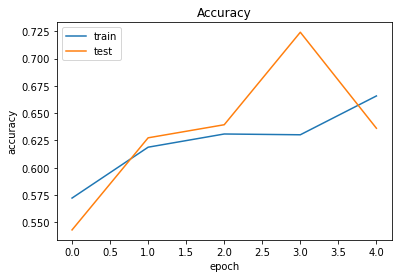

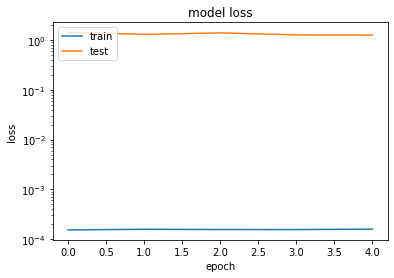

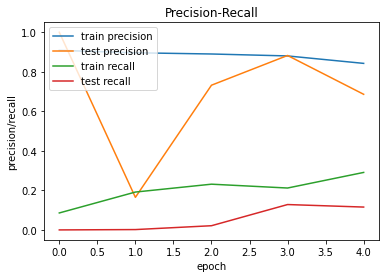

In [0]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
plt.show()

# summarize history for precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Precision-Recall')
plt.ylabel('precision/recall')
plt.xlabel('epoch')
plt.legend(['train precision', 'test precision', 'train recall', 'test recall'], loc='upper left')
plt.show()

In [0]:
model.save('/tmp/LSTMapproachWeigtedSamples')

WARNING:absl:Found untraced functions such as lstm_cell_3_layer_call_and_return_conditional_losses, lstm_cell_3_layer_call_fn, lstm_cell_3_layer_call_fn, lstm_cell_3_layer_call_and_return_conditional_losses, lstm_cell_3_layer_call_and_return_conditional_losses while saving (showing 5 of 5). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /tmp/LSTMapproachWeigtedSamples/assets
INFO:tensorflow:Assets written to: /tmp/LSTMapproachWeigtedSamples/assets

In [0]:
dbutils.fs.ls("file:/tmp/LSTMapproachWeigtedSamples/")
dbutils.fs.cp("file:/tmp/LSTMapproachWeigtedSamples/", "/FileStore/models/LSTMapproachWeigtedSamples/", recurse=True)

dbutils.fs.ls("/FileStore/models/")

Out[81]: [FileInfo(path='dbfs:/FileStore/models/LSTMapproachDownsampled/', name='LSTMapproachDownsampled/', size=0),
 FileInfo(path='dbfs:/FileStore/models/LSTMapproachWeigtedSamples/', name='LSTMapproachWeigtedSamples/', size=0),
 FileInfo(path='dbfs:/FileStore/models/TimeSeriesForest_downsampledData/', name='TimeSeriesForest_downsampledData/', size=0)]

In [0]:
# make predictions
predictions = model.predict(test_x)

In [0]:
from scipy.special import softmax

predicted_label = np.argmax(predictions, axis=1)
true_label = np.argmax(test_y, axis=1)
print('Predicted: {}, true: {}'.format(predicted_label, true_label))

Predicted: [1 5 3 ... 3 1 1], true: [1 1 0 ... 1 1 1]

In [0]:
df = pd.DataFrame(true_label, columns=['label'])
df['prediction'] = predicted_label
df_predictions = spark.createDataFrame(df)

from pyspark.sql.types import DoubleType
df_predictions = df_predictions.withColumn("label", df_predictions.label.cast(DoubleType()))  # cast to double as MulticlassClassificationEvaluator needs that
df_predictions = df_predictions.withColumn("prediction", df_predictions.prediction.cast(DoubleType()))

df_predictions.display()

label prediction 1.0 1.0 1.0 5.0 0.0 3.0 1.0 1.0 0.0 1.0 1.0 1.0 0.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 4.0 5.0 0.0 0.0 4.0 5.0 2.0 1.0 1.0 1.0 3.0 3.0 2.0 3.0 0.0 0.0 1.0 1.0 2.0 2.0 1.0 5.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0 3.0 3.0 0.0 3.0 1.0 1.0 1.0 1.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 3.0 1.0 1.0 1.0 1.0 0.0 3.0 1.0 1.0 1.0 1.0 1.0 3.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.0 1.0 1.0 0.0 0.0 3.0 3.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 3.0 2.0 3.0 0.0 3.0 1.0 1.0 0.0 0.0 1.0 2.0 2.0 3.0 0.0 0.0 2.0 0.0 1.0 1.0 0.0 0.0 0.0 3.0 0.0 0.0 1.0 1.0 0.0 3.0 0.0 0.0 6.0 5.0 1.0 1.0 0.0 0.0 1.0 1.0 0.0 3.0 1.0 1.0 0.0 3.0 0.0 3.0 0.0 3.0 0.0 3.0 1.0 1.0 0.0 3.0 0.0 3.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0 1.0 1.0 0.0 0.0 1.0 1.0 3.0 3.0 0.0 3.0 1.0 1.0 1.0 1.0 2.0 3.0 2.0 3.0 12.0 3.0 1.0 1.0 1.0 1.0 0.0 3.0 1.0 1.0 1.0 1.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 3.0 1.0 1.0 8.0 1.0 0.0 3.0 3.0 3.0 1.0 1.0 0.0 0.0 0.0 3.0 0.0 3.0 1.0 1.0 0.0 0.0 0.0 3.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 2.0 3.0 0.0 0.0 1.0 1.0 1.0 1.0 0.0 3.0 1.0 1.0 0.0 0.0 0.0 3.0 0.0 0.0 1.0 1.0 0.0 3.0 1.0 1.0 1.0 3.0 1.0 1.0 0.0 0.0 1.0 1.0 0.0 4.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 5.0 1.0 1.0 1.0 1.0 3.0 3.0 1.0 1.0 0.0 0.0 1.0 1.0 0.0 5.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.0 0.0 3.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0 2.0 3.0 1.0 5.0 1.0 1.0 0.0 0.0 1.0 5.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 3.0 3.0 1.0 1.0 0.0 3.0 1.0 1.0 8.0 1.0 0.0 3.0 1.0 1.0 1.0 1.0 0.0 3.0 4.0 5.0 0.0 0.0 1.0 1.0 0.0 5.0 0.0 3.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 3.0 0.0 2.0 0.0 3.0 3.0 0.0 1.0 1.0 0.0 3.0 1.0 1.0 0.0 0.0 2.0 1.0 1.0 1.0 0.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 3.0 1.0 1.0 1.0 1.0 0.0 0.0 3.0 3.0 1.0 1.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 6.0 1.0 0.0 0.0 0.0 3.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 3.0 0.0 5.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 3.0 3.0 5.0 1.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 3.0 0.0 5.0 0.0 0.0 2.0 3.0 0.0 3.0 0.0 3.0 0.0 0.0 0.0 0.0 0.0 3.0 0.0 3.0 2.0 3.0 0.0 0.0 1.0 5.0 1.0 1.0 0.0 0.0 1.0 1.0 3.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 0.0 0.0 3.0 7.0 1.0 0.0 3.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0 0.0 0.0 2.0 0.0 1.0 1.0 1.0 1.0 0.0 0.0 1.0 1.0 1.0 3.0 1.0 1.0 0.0 3.0 2.0 5.0 1.0 5.0 3.0 3.0 0.0 3.0 1.0 3.0 0.0 3.0 0.0 3.0 0.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 3.0 0.0 0.0 2.0 3.0 0.0 2.0 1.0 1.0 0.0 3.0 1.0 5.0 2.0 1.0 0.0 0.0 2.0 2.0 1.0 1.0 4.0 5.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 3.0 3.0 1.0 5.0 1.0 1.0 3.0 3.0 0.0 3.0 1.0 1.0 3.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 6.0 1.0 0.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 3.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 5.0 1.0 1.0 3.0 3.0 1.0 1.0 0.0 3.0 1.0 1.0 1.0 5.0 0.0 0.0 0.0 3.0 0.0 3.0 1.0 5.0 3.0 3.0 0.0 3.0 1.0 1.0 1.0 1.0 0.0 3.0 0.0 3.0 1.0 3.0 1.0 1.0 3.0 3.0 1.0 3.0 0.0 3.0 0.0 0.0 1.0 5.0 3.0 1.0 0.0 0.0 0.0 3.0 4.0 5.0 1.0 5.0 0.0 3.0 1.0 1.0 0.0 0.0 3.0 3.0 1.0 1.0 1.0 1.0 0.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 3.0 1.0 1.0 1.0 1.0 1.0 5.0 0.0 0.0 5.0 1.0 1.0 1.0 0.0 0.0 0.0 5.0 0.0 3.0 1.0 1.0 7.0 5.0 0.0 3.0 0.0 0.0 4.0 5.0 0.0 0.0 0.0 3.0 1.0 1.0 0.0 0.0 0.0 2.0 1.0 1.0 4.0 1.0 0.0 0.0 0.0 3.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 0.0 0.0 0.0 3.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 3.0 0.0 3.0 2.0 3.0 0.0 3.0 0.0 3.0 3.0 3.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0 1.0 3.0 0.0 3.0 1.0 1.0 1.0 1.0 2.0 0.0 0.0 3.0 0.0 3.0 1.0 1.0 3.0 3.0 0.0 0.0 1.0 1.0 1.0 1.0 0.0 0.0 3.0 3.0 1.0 1.0 1.0 1.0 2.0 1.0 2.0 3.0 1.0 1.0 1.0 1.0 0.0 3.0 0.0 0.0 0.0 0.0 0.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 3.0 3.0 0.0 0.0 3.0 3.0 1.0 1.0 1.0 1.0 0.0 0.0 1.0 1.0 0.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 3.0 0.0 3.0 0.0 3.0 3.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 3.0 0.0 0.0 0.0 3.0 1.0 1.0 1.0 1.0 2.0 0.0 2.0 3.0 0.0 0.0 1.0 1.0 1.0 1.0 0.0 3.0 2.0 0.0 0.0 3.0 10.0 3.0 2.0 3.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 3.0 0.0 0.0 0.0 0.0 0.0 3.0 1.0 1.0 1.0 1.0 0.0 0.0 1.0 1.0 0.0 3.0 5.0 1.0 0.0 3.0 1.0 1.0 1.0 1.0 0.0 0.0 0.0 3

In [0]:
def evaluate_model(predictions, metric="weightedPrecision"):
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    
    evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName=metric)

    return evaluator.evaluate(predictions)
  
def get_accuracy_matrix(predictionlabels):
    from pyspark.mllib.evaluation import MulticlassMetrics
    
    predictionlabels_rdd = predictionlabels.select("prediction", "label").rdd
    labels = predictionlabels_rdd.map(lambda lp: lp.label)
    
    metrics = MulticlassMetrics(predictionlabels_rdd)
    
    # Statistics by class
    labels = labels.distinct().collect()
    
    for label in sorted(labels):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    
    cm = metrics.confusionMatrix()
    
    return cm.toArray()

In [0]:
print("***** Test Set *****")
print("Weighted precision: {:.3f}".format(evaluate_model(df_predictions)))
print("Weighted Recall: {:.3f}".format(evaluate_model(df_predictions, metric="weightedRecall")))
print("Weighted F1: {:.3f}".format(evaluate_model(df_predictions, metric="weightedFMeasure")))
print("Weighted False Positive Rate: {:.3f}".format(evaluate_model(df_predictions, metric="weightedFalsePositiveRate")))
print("Accuracy: {:.3f}".format(evaluate_model(df_predictions, metric="accuracy")))

***** Test Set *****
Weighted precision: 0.795
Weighted Recall: 0.647
Weighted F1: 0.681
Weighted False Positive Rate: 0.061
Accuracy: 0.647

Class 0.0 precision = 0.8770481999760794
Class 0.0 recall = 0.5109748449585395
Class 0.0 F1 Measure = 0.6457379358929201
Class 1.0 precision = 0.9169385728472124
Class 1.0 recall = 0.9127303537386147
Class 1.0 F1 Measure = 0.9148296238632745
Class 2.0 precision = 0.3723076923076923
Class 2.0 recall = 0.0568609022556391
Class 2.0 F1 Measure = 0.09865470852017937
Class 3.0 precision = 0.12872644203312392
Class 3.0 recall = 0.7052565707133918
Class 3.0 F1 Measure = 0.21771467207572684
Class 4.0 precision = 0.29411764705882354
Class 4.0 recall = 0.04411764705882353
Class 4.0 F1 Measure = 0.07672634271099744
Class 5.0 precision = 0.09049313675648195
Class 5.0 recall = 0.7206477732793523
Class 5.0 F1 Measure = 0.16079494128274616
Class 6.0 precision = 0.0
Class 6.0 recall = 0.0
Class 6.0 F1 Measure = 0.0
Class 7.0 precision = 0.0
Class 7.0 recall = 0.0
Class 7.0 F1 Measure = 0.0
Class 8.0 precision = 0.0
Class 8.0 recall = 0.0
Class 8.0 F1 Measure = 0.0
Class 9.0 precision = 0.0
Class 9.0 recall = 0.0
Class 9.0 F1 Measure = 0.0
Class 10.0 precision = 0.0
Class 10.0 recall = 0.0
Class 10.0 F1 Measure = 0.0
Class 11.0 precision = 0.0
Class 11.0 recall = 0.0
Class 11.0 F1 Measure = 0.0
Class 12.0 precision = 0.0
Class 12.0 recall = 0.0
Class 12.0 F1 Measure = 0.0
Class 13.0 precision = 0.0
Class 13.0 recall = 0.0
Class 13.0 F1 Measure = 0.0
Class 14.0 precision = 0.0
Class 14.0 recall = 0.0
Class 14.0 F1 Measure = 0.0
Class 15.0 precision = 0.0
Class 15.0 recall = 0.0
Class 15.0 F1 Measure = 0.0
Class 16.0 precision = 0.0
Class 16.0 recall = 0.0
Class 16.0 F1 Measure = 0.0
Class 17.0 precision = 0.0
Class 17.0 recall = 0.0
Class 17.0 F1 Measure = 0.0
Class 18.0 precision = 0.0
Class 18.0 recall = 0.0
Class 18.0 F1 Measure = 0.0
Class 19.0 precision = 0.0
Class 19.0 recall = 0.0
Class 19.0 F1 Measure = 0.0
Class 20.0 precision = 0.0
Class 20.0 recall = 0.0
Class 20.0 F1 Measure = 0.0
Class 21.0 precision = 0.0
Class 21.0 recall = 0.0
Class 21.0 F1 Measure = 0.0
Class 22.0 precision = 0.0
Class 22.0 recall = 0.0
Class 22.0 F1 Measure = 0.0
Class 23.0 precision = 0.0
Class 23.0 recall = 0.0
Class 23.0 F1 Measure = 0.0
Class 24.0 precision = 0.0
Class 24.0 recall = 0.0
Class 24.0 F1 Measure = 0.0
Class 25.0 precision = 0.0
Class 25.0 recall = 0.0
Class 25.0 F1 Measure = 0.0
Class 26.0 precision = 0.0
Class 26.0 recall = 0.0
Class 26.0 F1 Measure = 0.0
Class 27.0 precision = 0.0
Class 27.0 recall = 0.0
Class 27.0 F1 Measure = 0.0
Class 28.0 precision = 0.0
Class 28.0 recall = 0.0
Class 28.0 F1 Measure = 0.0
Class 30.0 precision = 0.0
Class 30.0 recall = 0.0
Class 30.0 F1 Measure = 0.0
Class 31.0 precision = 0.0
Class 31.0 recall = 0.0
Class 31.0 F1 Measure = 0.0
Class 32.0 precision = 0.0
Class 32.0 recall = 0.0
Class 32.0 F1 Measure = 0.0
Class 33.0 precision = 0.0
Class 33.0 recall = 0.0
Class 33.0 F1 Measure = 0.0
Class 34.0 precision = 0.0
Class 34.0 recall = 0.0
Class 34.0 F1 Measure = 0.0
Class 38.0 precision = 0.0
Class 38.0 recall = 0.0
Class 38.0 F1 Measure = 0.0
Class 42.0 precision = 0.0
Class 42.0 recall = 0.0
Class 42.0 F1 Measure = 0.0

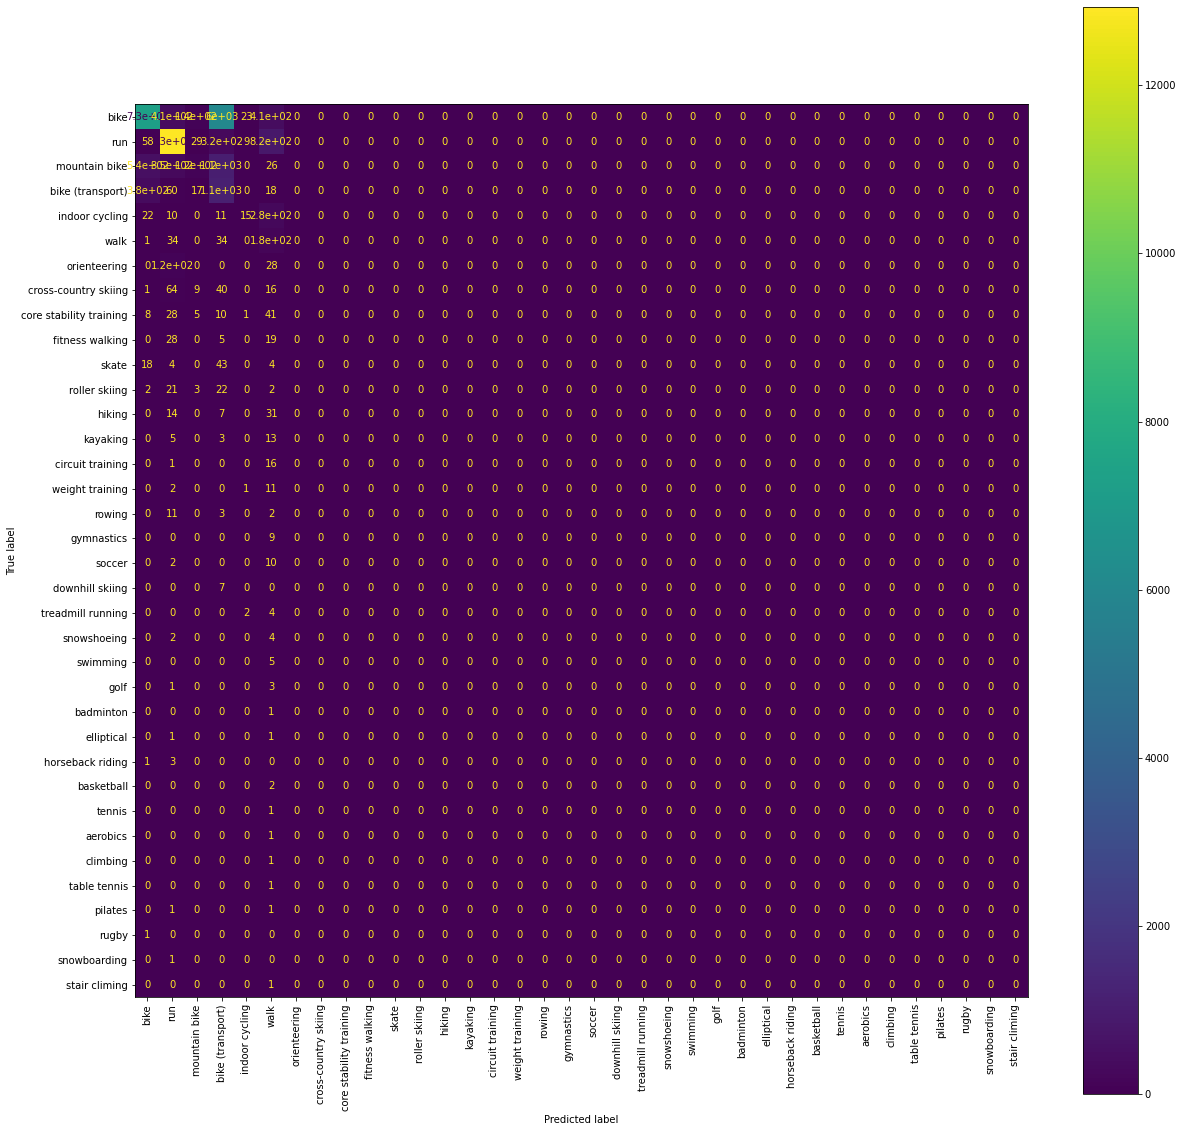

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = get_accuracy_matrix(df_predictions)

nr_labels = cm.shape[0]

ls = ['bike', 'run', 'mountain bike', 'bike (transport)', 'indoor cycling', 'walk', 'orienteering', 'cross-country skiing', 'core stability training', 'fitness walking', 'skate', 'roller skiing', 'hiking', 'kayaking', 'circuit training', 'weight training', 'rowing', 'gymnastics', 'soccer', 'downhill skiing', 'treadmill running', 'snowshoeing', 'swimming', 'golf', 'badminton', 'elliptical', 'horseback riding', 'basketball', 'tennis', 'aerobics', 'climbing', 'table tennis', 'pilates', 'rugby', 'snowboarding', 'stair climing', 'kite surfing', 'martial arts', 'sailing', 'squash', 'treadmill walking', 'windsurfing', 'yoga'] # list(range(nr_labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)

fig, ax = plt.subplots(figsize=(20,20))
disp.plot(ax=ax, xticks_rotation='vertical')

plt.show()

We can mainly see that the approach with sample weights still does not lead to the desired effect of solving the imbalance problem. More information are given in the presentation.

#### LSTM training for the balanced dataset using the downsampling strategy

This training uses the same dataset as the upper trained TimeSeriesForest. To use this code, apply the same data preparation as stated above in the preprocessing section (use the dowmsampling strategy).

In [0]:
#### NOTE: This is a newer training (as the results from a previous one were better, I used other plots for my presentation)

nr_classes = 10

# hyperparameters
epochs = 10
batch = 16
lr = 0.001
momentum = 0.3

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(500, 2)))
# model.add(Dropout(0.5))
model.add(Dense(30, activation='linear'))
# model.add(Dropout(0.5))
model.add(Dense(nr_classes, activation='softmax'))
model.summary()

opt = optimizers.RMSprop(lr, momentum)
model.compile(loss='CategoricalCrossentropy', optimizer=opt, metrics=['accuracy', 'Precision', 'Recall', 'mse'])

history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch, validation_data=(val_x, val_y), verbose=1, shuffle=False)

Model: "sequential"
_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
lstm (LSTM) (None, 50) 10600 
_________________________________________________________________
dense (Dense) (None, 30) 1530 
_________________________________________________________________
dense_1 (Dense) (None, 10) 310 
=================================================================
Total params: 12,440
Trainable params: 12,440
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 1/648 [..............................] - ETA: 36:49 - loss: 2.3211 - accuracy: 0.0625 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0904 2/648 [..............................] - ETA: 2:11 - loss: 2.3012 - accuracy: 0.0938 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0900  3/648 [..............................] - ETA: 2:09 - loss: 2.3008 - accuracy: 0.0625 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0900 4/648 [..............................] - ETA: 2:08 - loss: 2.2999 - accuracy: 0.0625 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0900 5/648 [..............................] - ETA: 2:07 - loss: 2.3039 - accuracy: 0.0750 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0900 6/648 [..............................] - ETA: 2:06 - loss: 2.3056 - accuracy: 0.0938 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0901 7/648 [..............................] - ETA: 2:06 - loss: 2.3073 - accuracy: 0.0982 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0901 8/648 [..............................] - ETA: 2:06 - loss: 2.3047 - accuracy: 0.1094 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0900 9/648 [..............................] - ETA: 2:06 - loss: 2.3042 - accuracy: 0.1042 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0900 10/648 [..............................] - ETA: 2:07 - loss: 2.3030 - accuracy: 0.1063 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0900 11/648 [..............................] - ETA: 2:07 - loss: 2.3041 - accuracy: 0.1023 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0900 12/648 [..............................] - ETA: 2:07 - loss: 2.3043 - accuracy: 0.0990 - precision: 0.0000e+00 - recall: 0.0000e+00 - mse: 0.0900

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'mse', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_mse'])

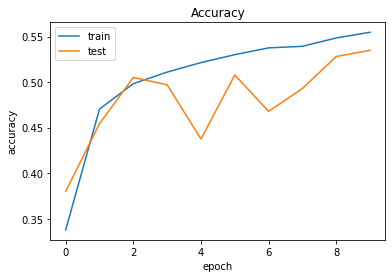

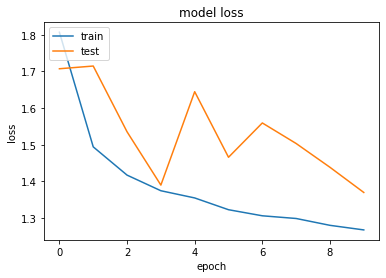

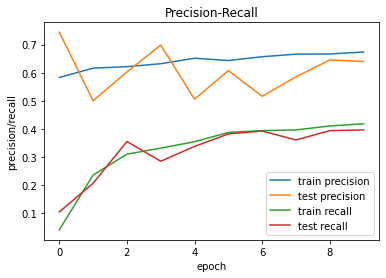

In [0]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Precision-Recall')
plt.ylabel('precision/recall')
plt.xlabel('epoch')
plt.legend(['train precision', 'test precision', 'train recall', 'test recall'], loc='lower right')
plt.show()

In [0]:
model.save_weights('/tmp/LSTMapproachDownsampled_WEIGHTS.h5')

In [0]:
dbutils.fs.ls("file:/tmp/")

Out[54]: [FileInfo(path='file:/tmp/LSTMapproachDownsampled_save.h5', name='LSTMapproachDownsampled_save.h5', size=134712),
 FileInfo(path='file:/tmp/chauffeur-daemon.pid', name='chauffeur-daemon.pid', size=4),
 FileInfo(path='file:/tmp/hsperfdata_root/', name='hsperfdata_root/', size=4096),
 FileInfo(path='file:/tmp/__pycache__/', name='__pycache__/', size=4096),
 FileInfo(path='file:/tmp/tmp6xqtxho6.py', name='tmp6xqtxho6.py', size=866),
 FileInfo(path='file:/tmp/.ICE-unix/', name='.ICE-unix/', size=4096),
 FileInfo(path='file:/tmp/.Test-unix/', name='.Test-unix/', size=4096),
 FileInfo(path='file:/tmp/.X11-unix/', name='.X11-unix/', size=4096),
 FileInfo(path='file:/tmp/custom-spark.conf', name='custom-spark.conf', size=216),
 FileInfo(path='file:/tmp/LSTMapproachDownsampled_save', name='LSTMapproachDownsampled_save', size=134712),
 FileInfo(path='file:/tmp/.XIM-unix/', name='.XIM-unix/', size=4096),
 FileInfo(path='file:/tmp/chauffeur-env.sh', name='chauffeur-env.sh', size=156),
 FileInfo(path='file:/tmp/systemd-private-5d4f54f294914e788607af12fd4b219c-systemd-resolved.service-wVkO6b/', name='systemd-private-5d4f54f294914e788607af12fd4b219c-systemd-resolved.service-wVkO6b/', size=4096),
 FileInfo(path='file:/tmp/tmp.EgUyfK2aj5', name='tmp.EgUyfK2aj5', size=0),
 FileInfo(path='file:/tmp/driver-daemon.pid', name='driver-daemon.pid', size=4),
 FileInfo(path='file:/tmp/.font-unix/', name='.font-unix/', size=4096),
 FileInfo(path='file:/tmp/tmp92zfivjb.py', name='tmp92zfivjb.py', size=866),
 FileInfo(path='file:/tmp/chauffeur-daemon-params', name='chauffeur-daemon-params', size=22),
 FileInfo(path='file:/tmp/systemd-private-5d4f54f294914e788607af12fd4b219c-ntp.service-qxhP5j/', name='systemd-private-5d4f54f294914e788607af12fd4b219c-ntp.service-qxhP5j/', size=4096),
 FileInfo(path='file:/tmp/Rserv/', name='Rserv/', size=4096),
 FileInfo(path='file:/tmp/driver-daemon-params', name='driver-daemon-params', size=19),
 FileInfo(path='file:/tmp/LSTMapproachDownsampled_WEIGHTS.h5', name='LSTMapproachDownsampled_WEIGHTS.h5', size=67616),
 FileInfo(path='file:/tmp/driver-env.sh', name='driver-env.sh', size=3029),
 FileInfo(path='file:/tmp/systemd-private-5d4f54f294914e788607af12fd4b219c-apache2.service-J9UYBX/', name='systemd-private-5d4f54f294914e788607af12fd4b219c-apache2.service-J9UYBX/', size=4096),
 FileInfo(path='file:/tmp/bdc-2020-21/', name='bdc-2020-21/', size=4096),
 FileInfo(path='file:/tmp/RtmpfEpcBd/', name='RtmpfEpcBd/', size=4096)]

In [0]:
def load_model(model_path, nr_classes=10):
    model = Sequential()
    model.add(LSTM(50, input_shape=(500, 2)))
    # model.add(Dropout(0.5))
    model.add(Dense(30, activation='linear'))
    # model.add(Dropout(0.5))
    model.add(Dense(nr_classes, activation='softmax'))

    model.load_weights(model_path)
    
    return model
  
# move file to local file system
dbutils.fs.cp("dbfs:/bdc-2020-21/LSTMapproachDownsampled_WEIGHTS.h5", "file:/tmp/LSTMapproachDownsampled_WEIGHTS_NEW.h5")  # uncomment if not needed
  
model = load_model(model_path="/tmp/LSTMapproachDownsampled_WEIGHTS_NEW.h5")

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
lstm (LSTM) (None, 50) 10600 
_________________________________________________________________
dense (Dense) (None, 30) 1530 
_________________________________________________________________
dense_1 (Dense) (None, 10) 310 
=================================================================
Total params: 12,440
Trainable params: 12,440
Non-trainable params: 0
_________________________________________________________________

In [0]:
# make predictions
predictions = model.predict(test_x)

In [0]:
predictions[0]

Out[17]: array([0.0164429 , 0.48760352, 0.41669413, 0.00092153, 0.00678272,
 0.02629363, 0.00250442, 0.00147161, 0.03674086, 0.00454466],
 dtype=float32)

In [0]:
from scipy.special import softmax

predicted_label = np.argmax(predictions, axis=1)
true_label = np.argmax(test_y, axis=1)
print('Predicted: {}, true: {}'.format(predicted_label, true_label))

Predicted: [1 4 6 ... 2 1 2], true: [1 7 5 ... 8 1 1]

In [0]:
df = pd.DataFrame(true_label, columns=['label'])
df['prediction'] = predicted_label
df_predictions = spark.createDataFrame(df)

from pyspark.sql.types import DoubleType
df_predictions = df_predictions.withColumn("label", df_predictions.label.cast(DoubleType()))  # cast to double as MulticlassClassificationEvaluator needs that
df_predictions = df_predictions.withColumn("prediction", df_predictions.prediction.cast(DoubleType()))

df_predictions.display()

label prediction 1.0 1.0 7.0 4.0 5.0 6.0 2.0 2.0 2.0 2.0 5.0 2.0 1.0 2.0 2.0 2.0 0.0 2.0 5.0 1.0 2.0 3.0 3.0 3.0 7.0 3.0 5.0 4.0 4.0 4.0 3.0 3.0 6.0 6.0 1.0 2.0 4.0 2.0 3.0 3.0 1.0 2.0 2.0 2.0 7.0 4.0 8.0 2.0 7.0 3.0 9.0 2.0 6.0 6.0 3.0 3.0 5.0 6.0 2.0 2.0 8.0 3.0 5.0 6.0 5.0 2.0 0.0 2.0 4.0 4.0 4.0 4.0 0.0 1.0 1.0 1.0 6.0 4.0 5.0 4.0 0.0 0.0 3.0 3.0 3.0 3.0 1.0 1.0 1.0 0.0 5.0 6.0 3.0 3.0 3.0 3.0 3.0 3.0 1.0 1.0 7.0 8.0 0.0 2.0 1.0 0.0 2.0 2.0 8.0 2.0 2.0 2.0 6.0 6.0 5.0 6.0 2.0 0.0 3.0 6.0 1.0 2.0 8.0 3.0 3.0 3.0 1.0 2.0 7.0 4.0 8.0 5.0 4.0 4.0 4.0 2.0 3.0 3.0 2.0 2.0 4.0 4.0 3.0 3.0 7.0 3.0 7.0 7.0 5.0 0.0 3.0 3.0 4.0 4.0 1.0 1.0 1.0 0.0 9.0 2.0 2.0 2.0 4.0 4.0 3.0 3.0 0.0 0.0 6.0 6.0 1.0 2.0 8.0 8.0 5.0 4.0 3.0 3.0 3.0 3.0 2.0 2.0 4.0 4.0 6.0 4.0 0.0 0.0 1.0 2.0 5.0 4.0 2.0 2.0 8.0 3.0 5.0 3.0 0.0 2.0 5.0 4.0 3.0 7.0 3.0 3.0 4.0 4.0 5.0 6.0 5.0 6.0 3.0 3.0 7.0 3.0 1.0 2.0 6.0 6.0 1.0 2.0 4.0 4.0 5.0 2.0 4.0 4.0 5.0 2.0 0.0 0.0 5.0 6.0 0.0 2.0 2.0 8.0 8.0 2.0 4.0 4.0 3.0 3.0 4.0 4.0 1.0 2.0 2.0 5.0 8.0 6.0 6.0 6.0 7.0 3.0 2.0 2.0 1.0 0.0 3.0 3.0 2.0 2.0 4.0 4.0 1.0 1.0 7.0 5.0 0.0 1.0 1.0 2.0 4.0 4.0 2.0 3.0 6.0 5.0 0.0 2.0 0.0 0.0 3.0 3.0 9.0 4.0 3.0 3.0 8.0 7.0 2.0 2.0 4.0 4.0 0.0 0.0 4.0 4.0 3.0 3.0 0.0 2.0 2.0 2.0 4.0 2.0 4.0 4.0 6.0 6.0 2.0 2.0 2.0 2.0 0.0 0.0 6.0 6.0 4.0 4.0 8.0 2.0 5.0 5.0 4.0 2.0 0.0 2.0 0.0 0.0 7.0 7.0 4.0 4.0 3.0 3.0 4.0 4.0 5.0 8.0 1.0 1.0 0.0 2.0 8.0 2.0 1.0 2.0 4.0 4.0 1.0 2.0 2.0 2.0 7.0 3.0 2.0 2.0 7.0 7.0 4.0 2.0 3.0 3.0 4.0 4.0 7.0 3.0 5.0 4.0 3.0 3.0 5.0 4.0 2.0 2.0 5.0 6.0 2.0 2.0 0.0 0.0 5.0 6.0 5.0 3.0 4.0 1.0 2.0 2.0 1.0 1.0 6.0 6.0 2.0 2.0 7.0 4.0 0.0 2.0 3.0 3.0 2.0 2.0 4.0 4.0 6.0 6.0 2.0 2.0 2.0 2.0 5.0 2.0 1.0 0.0 3.0 6.0 4.0 4.0 7.0 3.0 7.0 3.0 8.0 2.0 5.0 6.0 4.0 4.0 6.0 8.0 1.0 2.0 5.0 2.0 0.0 2.0 2.0 2.0 2.0 2.0 3.0 3.0 3.0 3.0 3.0 6.0 8.0 2.0 3.0 3.0 5.0 4.0 0.0 2.0 0.0 2.0 3.0 6.0 2.0 2.0 3.0 3.0 7.0 3.0 7.0 7.0 0.0 0.0 5.0 4.0 4.0 4.0 0.0 2.0 7.0 7.0 0.0 2.0 0.0 0.0 8.0 2.0 6.0 6.0 4.0 1.0 1.0 2.0 3.0 3.0 1.0 1.0 5.0 2.0 7.0 3.0 0.0 0.0 2.0 2.0 7.0 3.0 4.0 4.0 3.0 3.0 6.0 6.0 3.0 3.0 5.0 5.0 2.0 2.0 7.0 7.0 1.0 2.0 5.0 5.0 2.0 2.0 0.0 2.0 3.0 6.0 1.0 1.0 6.0 6.0 9.0 2.0 4.0 4.0 1.0 1.0 8.0 8.0 0.0 0.0 3.0 3.0 5.0 1.0 3.0 6.0 7.0 4.0 8.0 4.0 3.0 5.0 3.0 3.0 1.0 0.0 6.0 6.0 1.0 1.0 3.0 3.0 8.0 6.0 4.0 4.0 3.0 3.0 9.0 4.0 2.0 2.0 0.0 2.0 6.0 6.0 5.0 8.0 7.0 4.0 5.0 5.0 7.0 3.0 4.0 4.0 8.0 8.0 5.0 2.0 1.0 1.0 5.0 6.0 0.0 0.0 7.0 3.0 0.0 1.0 7.0 7.0 4.0 4.0 5.0 6.0 2.0 1.0 8.0 2.0 0.0 0.0 1.0 0.0 2.0 2.0 2.0 2.0 4.0 4.0 1.0 2.0 1.0 2.0 4.0 4.0 7.0 7.0 1.0 2.0 1.0 2.0 0.0 0.0 6.0 6.0 2.0 2.0 6.0 6.0 1.0 0.0 2.0 2.0 0.0 0.0 5.0 6.0 2.0 2.0 1.0 2.0 4.0 4.0 1.0 2.0 1.0 4.0 0.0 2.0 2.0 2.0 7.0 4.0 3.0 3.0 6.0 6.0 3.0 3.0 1.0 1.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 1.0 1.0 0.0 2.0 6.0 6.0 3.0 3.0 4.0 4.0 3.0 3.0 5.0 4.0 4.0 4.0 2.0 2.0 0.0 2.0 1.0 2.0 4.0 2.0 4.0 4.0 4.0 2.0 8.0 7.0 9.0 2.0 0.0 0.0 3.0 3.0 2.0 2.0 8.0 2.0 1.0 2.0 0.0 1.0 5.0 4.0 3.0 3.0 1.0 2.0 2.0 2.0 4.0 4.0 0.0 0.0 6.0 6.0 0.0 0.0 3.0 6.0 4.0 4.0 2.0 2.0 3.0 3.0 8.0 2.0 1.0 0.0 5.0 6.0 9.0 3.0 0.0 0.0 3.0 3.0 0.0 0.0 3.0 3.0 0.0 1.0 1.0 2.0 1.0 2.0 0.0 2.0 6.0 6.0 4.0 4.0 1.0 1.0 4.0 4.0 3.0 3.0 4.0 4.0 1.0 0.0 8.0 7.0 0.0 1.0 0.0 2.0 6.0 6.0 8.0 2.0 0.0 0.0 6.0 6.0 4.0 2.0 5.0 3.0 5.0 6.0 5.0 4.0 8.0 1.0 4.0 4.0 1.0 8.0 3.0 3.0 3.0 3.0 6.0 6.0 3.0 3.0 1.0 1.0 6.0 5.0 0.0 0.0 6.0 4.0 2.0 1.0 2.0 2.0 3.0 3.0 2.0 2.0 3.0 3.0 4.0 4.0 3.0 3.0 5.0 5.0 0.0 0.0 0.0 0.0 3.0 3.0 3.0 3.0 4.0 4.0 3.0 3.0 6.0 6.0 5.0 4.0 1.0 2.0 3.0 3.0 5.0 1.0 5.0 6.0 5.0 5.0 1.0 2.0 0.0 0.0 5.0 3.0 3.0 3.0 0.0 0.0 8.0 3.0 0.0 2.0 7.0 4.0 6.0 6.0 8.0 2.0 4.0 0.0 1.0 2.0 4.0 4.0 4.0 4.0 3.0 3.0 1.0 1.0 4.0 2.0 9.0 6.0 2.0 2.0 7.0 7.0 5.0 4.0 5.0 4.0 1.0 1.0 7.0 6.0 0.0 0.0 8.0 3.0 6.0 6.0 2.0 2.0 7.0 6.0 7.0 7.0 3.0 3.0 0.0 2.0 3.0 3.0 3.0 3.0 1.0 1.0 2.0 2.0 5.0 4.0 9.0 4.0 5.0 2.0 3.0 3.0 5.0 4.0 3.0 3.0 1.0 1.0 4.0 2.0 2.0 2.0 3.0 3.0 6.0 6.0 0.0 0.0 1.0 2.0 4.0 4.0 0.0 1.0 2.0 0.0 3.0 3.0 3.0 3.0 1.0 2.0 3.0 3.0 5.0 2.0 1.0 2.0 0.0 2.0 2.0 2.0

### Evaluation of LSTM Downsampling Approach

In [0]:
def evaluate_model(predictions, metric="weightedPrecision"):
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    
    evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName=metric)

    return evaluator.evaluate(predictions)
  
def get_accuracy_matrix(predictionlabels):
    from pyspark.mllib.evaluation import MulticlassMetrics
    
    predictionlabels_rdd = predictionlabels.select("prediction", "label").rdd
    labels = predictionlabels_rdd.map(lambda lp: lp.label)
    
    metrics = MulticlassMetrics(predictionlabels_rdd)
    
    # Statistics by class
    labels = labels.distinct().collect()
    
    for label in sorted(labels):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    
    cm = metrics.confusionMatrix()
    
    return cm.toArray()

In [0]:
print("***** Test Set *****")
print("Weighted precision: {:.3f}".format(evaluate_model(df_predictions)))
print("Weighted Recall: {:.3f}".format(evaluate_model(df_predictions, metric="weightedRecall")))
print("Weighted F1: {:.3f}".format(evaluate_model(df_predictions, metric="weightedFMeasure")))
print("Weighted False Positive Rate: {:.3f}".format(evaluate_model(df_predictions, metric="weightedFalsePositiveRate")))
print("Accuracy: {:.3f}".format(evaluate_model(df_predictions, metric="accuracy")))

***** Test Set *****
Weighted precision: 0.526
Weighted Recall: 0.534
Weighted F1: 0.494
Weighted False Positive Rate: 0.062
Accuracy: 0.534

Class 0.0 precision = 0.7436823104693141
Class 0.0 recall = 0.508641975308642
Class 0.0 F1 Measure = 0.6041055718475072
Class 1.0 precision = 0.6028368794326241
Class 1.0 recall = 0.4166666666666667
Class 1.0 F1 Measure = 0.4927536231884058
Class 2.0 precision = 0.36341756919374246
Class 2.0 recall = 0.7823834196891192
Class 2.0 F1 Measure = 0.49630238290879203
Class 3.0 precision = 0.7257019438444925
Class 3.0 recall = 0.8421052631578947
Class 3.0 F1 Measure = 0.7795823665893271
Class 4.0 precision = 0.544
Class 4.0 recall = 0.8607594936708861
Class 4.0 F1 Measure = 0.6666666666666666
Class 5.0 precision = 0.28
Class 5.0 recall = 0.08383233532934131
Class 5.0 F1 Measure = 0.12903225806451613
Class 6.0 precision = 0.6051873198847262
Class 6.0 recall = 0.7865168539325843
Class 6.0 F1 Measure = 0.6840390879478827
Class 7.0 precision = 0.6
Class 7.0 recall = 0.27692307692307694
Class 7.0 F1 Measure = 0.37894736842105264
Class 8.0 precision = 0.34285714285714286
Class 8.0 recall = 0.15
Class 8.0 F1 Measure = 0.20869565217391303
Class 9.0 precision = 0.0
Class 9.0 recall = 0.0
Class 9.0 F1 Measure = 0.0

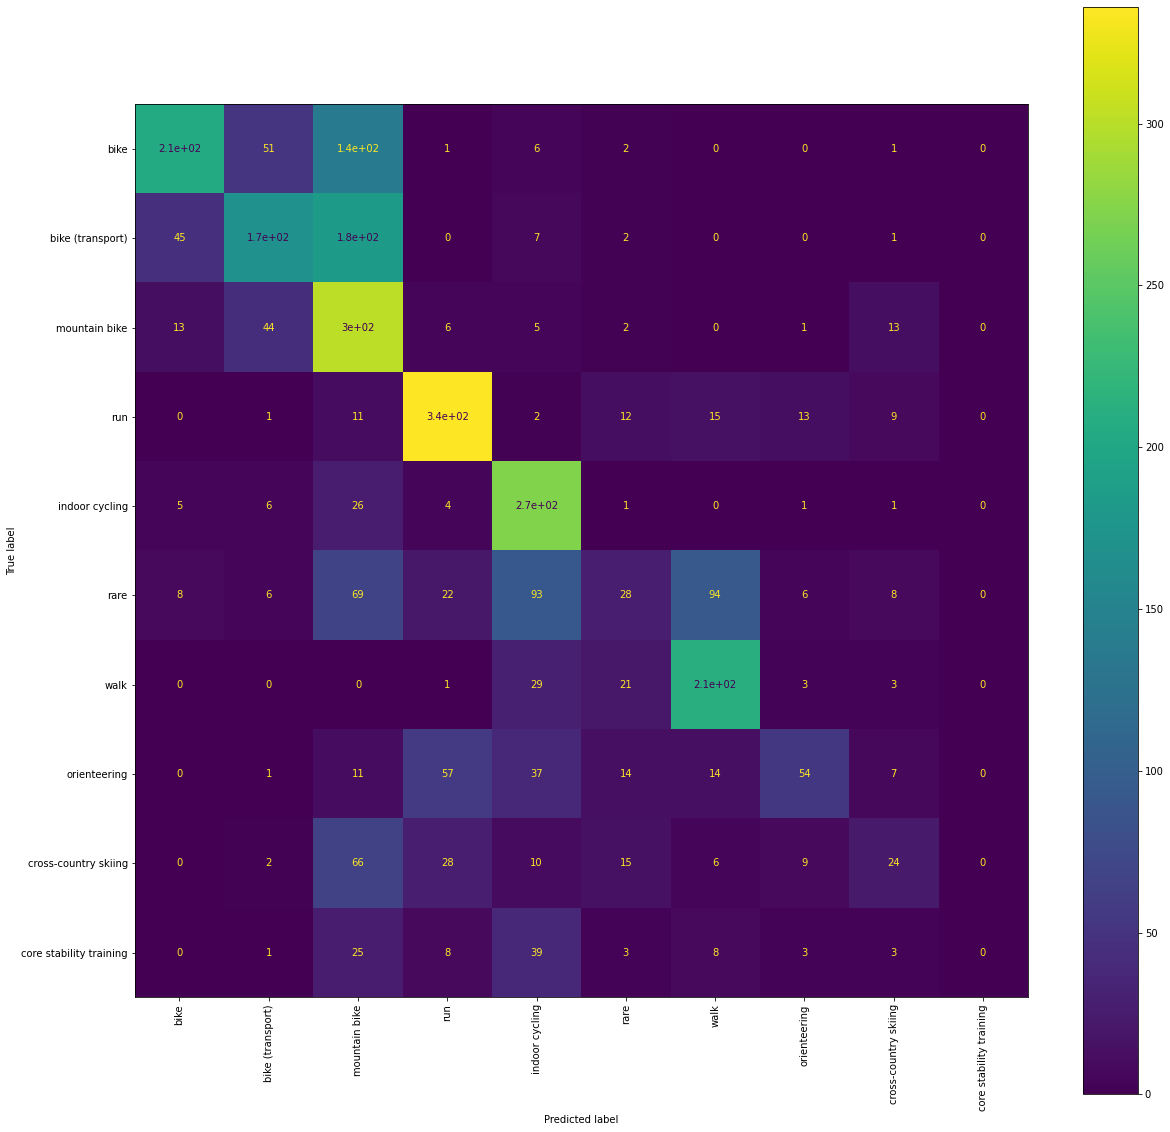

In [0]:
# Code snippet for demo -> one on original train/test shown below! (due to randomized shuffling and random train/test split, the results might be different than shown on the original train/test scenario shown in my presentation)

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = get_accuracy_matrix(df_predictions)

nr_labels = cm.shape[0]

ls = ['bike', 'bike (transport)', 'mountain bike', 'run', 'indoor cycling', 'rare', 'walk', 'orienteering', 'cross-country skiing', 'core stability training'] # list(range(nr_labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)

fig, ax = plt.subplots(figsize=(20,20))
disp.plot(ax=ax, xticks_rotation='vertical')

plt.show()

Class 0.0 precision = 0.5827702702702703
Class 0.0 recall = 0.8023255813953488
Class 0.0 F1 Measure = 0.675146771037182
Class 1.0 precision = 0.5495049504950495
Class 1.0 recall = 0.5721649484536082
Class 1.0 F1 Measure = 0.5606060606060606
Class 2.0 precision = 0.5248756218905473
Class 2.0 recall = 0.5396419437340153
Class 2.0 F1 Measure = 0.5321563682219419
Class 3.0 precision = 0.7
Class 3.0 recall = 0.8301886792452831
Class 3.0 F1 Measure = 0.7595561035758323
Class 4.0 precision = 0.7411167512690355
Class 4.0 recall = 0.8439306358381503
Class 4.0 F1 Measure = 0.7891891891891893
Class 5.0 precision = 0.32954545454545453
Class 5.0 recall = 0.08357348703170028
Class 5.0 F1 Measure = 0.13333333333333333
Class 6.0 precision = 0.5344418052256532
Class 6.0 recall = 0.907258064516129
Class 6.0 F1 Measure = 0.672645739910314
Class 7.0 precision = 0.46835443037974683
Class 7.0 recall = 0.4484848484848485
Class 7.0 F1 Measure = 0.45820433436532504
Class 8.0 precision = 0.4262295081967213
Class 8.0 recall = 0.15950920245398773
Class 8.0 F1 Measure = 0.23214285714285712
Class 9.0 precision = 0.0
Class 9.0 recall = 0.0
Class 9.0 F1 Measure = 0.0

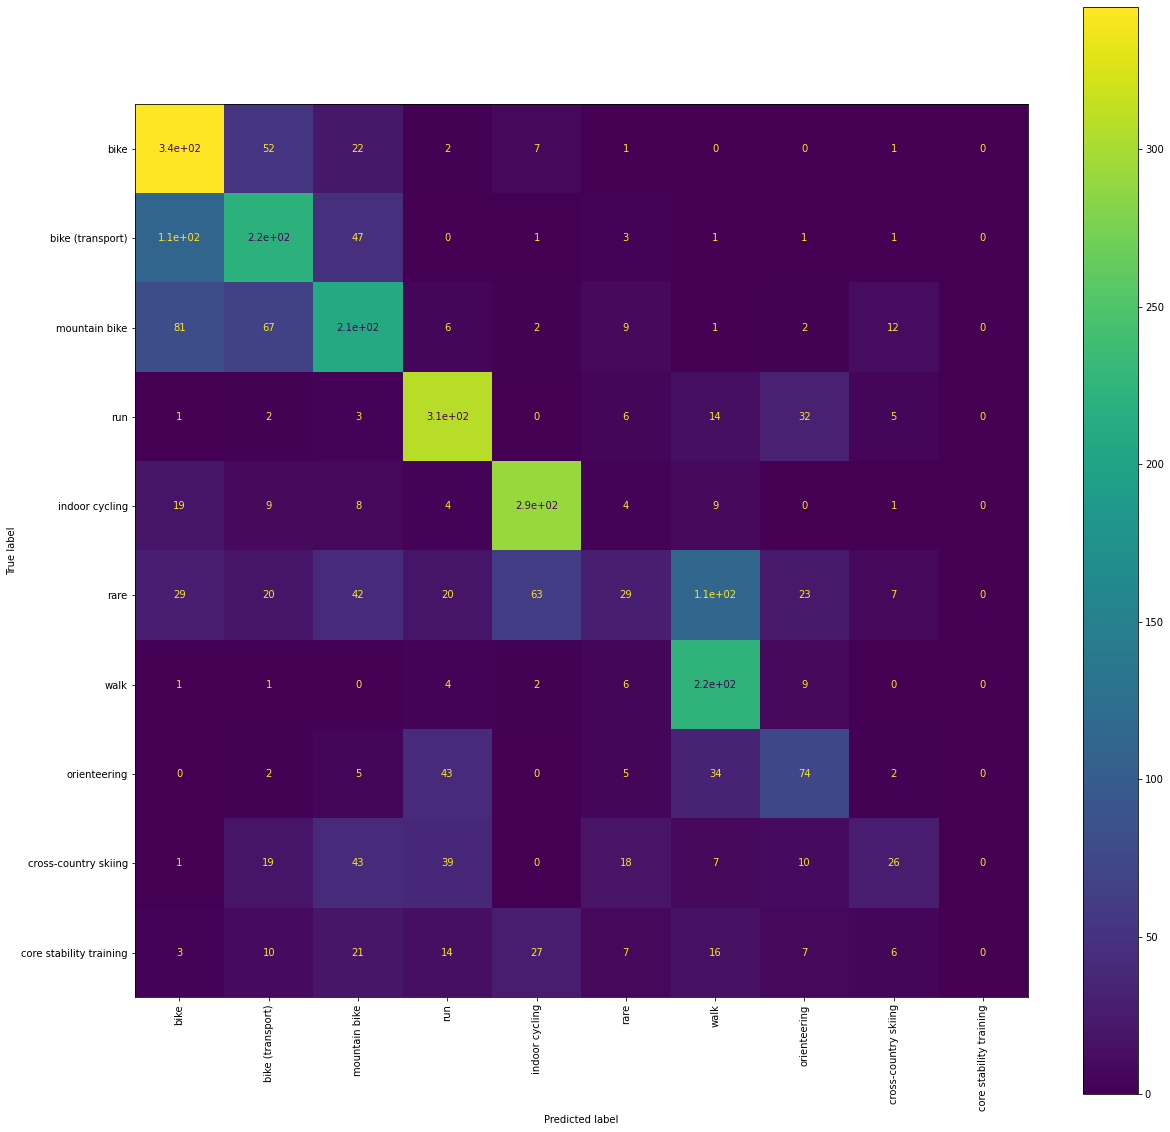

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = get_accuracy_matrix(df_predictions)

nr_labels = cm.shape[0]

ls = ['bike', 'bike (transport)', 'mountain bike', 'run', 'indoor cycling', 'rare', 'walk', 'orienteering', 'cross-country skiing', 'core stability training'] # list(range(nr_labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)

fig, ax = plt.subplots(figsize=(20,20))
disp.plot(ax=ax, xticks_rotation='vertical')

plt.show()